In [192]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth, approach_one_100
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:
$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\pi^a_i} & - \delta \phi(y) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_i \hat 
\pi^a_i \theta_i \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& + \xi_a \sum_i \hat \pi^a_i (\log \hat \pi^a_i - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [267]:
# parameters
δ = 0.01
η = 0.032
ξa = 1/100
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
# λ = np.log(2)/6
λ = 0.116
# numy_bar = 50
# y_min = 0
# y_max = 4
# hy = (ȳ - y_min)/numy_bar
# y1_grid = np.arange(y_min, y_max+hy, hy)

# # y1_grid = np.linspace(0, 4, 50)
# y2_grid = np.linspace(0, 0.05, 50)
# # mesh grid and construct state space
# (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
# stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
# hy1 = y1_grid[1] - y1_grid[0]
# hy2 = y2_grid[1] - y2_grid[0]
# n_y1 = len(y1_grid)
# n_y2 = len(y2_grid)

In [306]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)
y1_grid_cap = np.arange(0., 2.+y1_step, y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [309]:
tol = 1e-7
ϵ = 0.5
max_iter = 5_000
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o
solu=dict()
for i in range(3):
    π_p = np.zeros(3)
    π_p[i] = 1
    dΛ1 = γ1 + γ2*y1_mat + π_p@γ3_list*(y1_mat - ȳ)*(y1_mat >ȳ)
# ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
    #     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
    #     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
        πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
        print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    result = dict(v0=v0, ems=ems, πa=πa)
    solu[π_p@γ3_list] = result

256.74921569604373
Episode 0: PDE Error: 0.231232402737; False Transient Error: 0.166567388810; Iterations: 10000; CG Error: 0.000008320961
End of PDE solver, takes time: 0.5310485363006592
187.03117000230907
Episode 1: PDE Error: 0.167281206393; False Transient Error: 0.130949315208; Iterations: 10000; CG Error: 0.000001111310
End of PDE solver, takes time: 0.5299441814422607
123.68728262142207
Episode 2: PDE Error: 0.138625561488; False Transient Error: 0.138799996490; Iterations: 10000; CG Error: 0.000000730593
End of PDE solver, takes time: 0.5423271656036377
83.01287084804628
Episode 3: PDE Error: 0.144193494858; False Transient Error: 0.146121191894; Iterations: 10000; CG Error: 0.000002878427
End of PDE solver, takes time: 0.5345363616943359
58.06719502304375
Episode 4: PDE Error: 0.147534150376; False Transient Error: 0.145663502323; Iterations: 10000; CG Error: 0.000004719973
End of PDE solver, takes time: 0.534886360168457
41.938030627530274
Episode 5: PDE Error: 0.1470552396

7.9268889637894535
Episode 44: PDE Error: 0.065051510856; False Transient Error: 0.064471018580; Iterations: 78; CG Error: 0.000000000079
End of PDE solver, takes time: 0.005728960037231445
7.884695346092682
Episode 45: PDE Error: 0.064470997099; False Transient Error: 0.063849915040; Iterations: 77; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0057277679443359375
7.8449689334103425
Episode 46: PDE Error: 0.063850207703; False Transient Error: 0.063240817288; Iterations: 76; CG Error: 0.000000000098
End of PDE solver, takes time: 0.005492687225341797
7.807534469209482
Episode 47: PDE Error: 0.063241368032; False Transient Error: 0.062692916465; Iterations: 76; CG Error: 0.000000000085
End of PDE solver, takes time: 0.005502223968505859
7.772231157519599
Episode 48: PDE Error: 0.062692857517; False Transient Error: 0.062112837639; Iterations: 76; CG Error: 0.000000000076
End of PDE solver, takes time: 0.00557398796081543
7.738911225727059
Episode 49: PDE Error: 0.0621132100

7.144869159197038
Episode 93: PDE Error: 0.038168353690; False Transient Error: 0.037754598292; Iterations: 55; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0044939517974853516
7.139454329830306
Episode 94: PDE Error: 0.037802977255; False Transient Error: 0.037396712864; Iterations: 55; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004286527633666992
7.1341658635193905
Episode 95: PDE Error: 0.037445454514; False Transient Error: 0.037046436432; Iterations: 55; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004380941390991211
7.12899767447582
Episode 96: PDE Error: 0.037095531136; False Transient Error: 0.036703520758; Iterations: 55; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004370212554931641
7.123944025934405
Episode 97: PDE Error: 0.036752959140; False Transient Error: 0.036367723556; Iterations: 54; CG Error: 0.000000000100
End of PDE solver, takes time: 0.004419565200805664
7.118999500814714
Episode 98: PDE Error: 0.03641749617

6.960259701758711
Episode 143: PDE Error: 0.025733600498; False Transient Error: 0.025493741479; Iterations: 51; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004319906234741211
6.957581727699646
Episode 144: PDE Error: 0.025552678293; False Transient Error: 0.025314266899; Iterations: 51; CG Error: 0.000000000072
End of PDE solver, takes time: 0.004038572311401367
6.9549279939444
Episode 145: PDE Error: 0.025373326833; False Transient Error: 0.025136345227; Iterations: 51; CG Error: 0.000000000071
End of PDE solver, takes time: 0.00414276123046875
6.952297963433502
Episode 146: PDE Error: 0.025195526581; False Transient Error: 0.024959957947; Iterations: 51; CG Error: 0.000000000070
End of PDE solver, takes time: 0.004135608673095703
6.949691108224351
Episode 147: PDE Error: 0.025019259061; False Transient Error: 0.024785087318; Iterations: 50; CG Error: 0.000000000100
End of PDE solver, takes time: 0.004116535186767578
6.947106906687766
Episode 148: PDE Error: 0.024844506

6.847022561891983
Episode 194: PDE Error: 0.018204364833; False Transient Error: 0.018022119104; Iterations: 50; CG Error: 0.000000000070
End of PDE solver, takes time: 0.004026889801025391
6.845188205760003
Episode 195: PDE Error: 0.018085701746; False Transient Error: 0.017904302408; Iterations: 50; CG Error: 0.000000000069
End of PDE solver, takes time: 0.004146575927734375
6.8433667446437845
Episode 196: PDE Error: 0.017967951087; False Transient Error: 0.017787389314; Iterations: 50; CG Error: 0.000000000069
End of PDE solver, takes time: 0.00406336784362793
6.841558093044013
Episode 197: PDE Error: 0.017851103323; False Transient Error: 0.017671370443; Iterations: 50; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0041522979736328125
6.839762164842593
Episode 198: PDE Error: 0.017735149086; False Transient Error: 0.017556236582; Iterations: 50; CG Error: 0.000000000068
End of PDE solver, takes time: 0.004132509231567383
6.837978873337021
Episode 199: PDE Error: 0.01762

Episode 246: PDE Error: 0.013071484979; False Transient Error: 0.012924335329; Iterations: 49; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0039653778076171875
6.765542344552543
Episode 247: PDE Error: 0.012990591329; False Transient Error: 0.012843980581; Iterations: 49; CG Error: 0.000000000071
End of PDE solver, takes time: 0.004190206527709961
6.764274311614189
Episode 248: PDE Error: 0.012910275447; False Transient Error: 0.012764199546; Iterations: 49; CG Error: 0.000000000071
End of PDE solver, takes time: 0.004068613052368164
6.76301490286578
Episode 249: PDE Error: 0.012830532880; False Transient Error: 0.012684987805; Iterations: 49; CG Error: 0.000000000070
End of PDE solver, takes time: 0.004008054733276367
6.761764054019617
Episode 250: PDE Error: 0.012751359211; False Transient Error: 0.012606340974; Iterations: 49; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003966569900512695
6.760521701401096
Episode 251: PDE Error: 0.012672750060; False Tran

6.7106635108947525
Episode 298: PDE Error: 0.009540468356; False Transient Error: 0.009416495583; Iterations: 48; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004225254058837891
6.709764120256239
Episode 299: PDE Error: 0.009484311553; False Transient Error: 0.009360696004; Iterations: 48; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004151582717895508
6.708870699944104
Episode 300: PDE Error: 0.009428534141; False Transient Error: 0.009305272780; Iterations: 48; CG Error: 0.000000000076
End of PDE solver, takes time: 0.003915309906005859
6.707983208209448
Episode 301: PDE Error: 0.009373132845; False Transient Error: 0.009250222653; Iterations: 48; CG Error: 0.000000000076
End of PDE solver, takes time: 0.003919124603271484
6.707101603670189
Episode 302: PDE Error: 0.009318104409; False Transient Error: 0.009195542387; Iterations: 48; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003981590270996094
6.706225845326589
Episode 303: PDE Error: 0.00926

Episode 349: PDE Error: 0.007098236936; False Transient Error: 0.006989085360; Iterations: 47; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004353523254394531
6.671065583344512
Episode 350: PDE Error: 0.007057786771; False Transient Error: 0.006948867604; Iterations: 47; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003947257995605469
6.6704341496872335
Episode 351: PDE Error: 0.007017582563; False Transient Error: 0.006908894017; Iterations: 47; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003907680511474609
6.66980699245264
Episode 352: PDE Error: 0.006977622415; False Transient Error: 0.006869162723; Iterations: 47; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003976106643676758
6.669184062132989
Episode 353: PDE Error: 0.006937904452; False Transient Error: 0.006829671873; Iterations: 47; CG Error: 0.000000000081
End of PDE solver, takes time: 0.00409245491027832
6.668565308749153
Episode 354: PDE Error: 0.006898426828; False Trans

6.647189305970178
Episode 393: PDE Error: 0.005528996371; False Transient Error: 0.005428645209; Iterations: 46; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003983020782470703
6.646701123550141
Episode 394: PDE Error: 0.005497856984; False Transient Error: 0.005397677357; Iterations: 46; CG Error: 0.000000000095
End of PDE solver, takes time: 0.003776073455810547
6.646215606680805
Episode 395: PDE Error: 0.005466898998; False Transient Error: 0.005366889832; Iterations: 46; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0038726329803466797
6.645732746333168
Episode 396: PDE Error: 0.005436121273; False Transient Error: 0.005336281504; Iterations: 46; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003796815872192383
6.645252532946287
Episode 397: PDE Error: 0.005405522682; False Transient Error: 0.005305851256; Iterations: 46; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003877878189086914
6.644774957424035
Episode 398: PDE Error: 0.00537

6.6278094349990315
Episode 438: PDE Error: 0.004292493372; False Transient Error: 0.004198914214; Iterations: 46; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0037772655487060547
6.6274376275775975
Episode 439: PDE Error: 0.004268512663; False Transient Error: 0.004175064315; Iterations: 46; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0039348602294921875
6.627068247512147
Episode 440: PDE Error: 0.004244670162; False Transient Error: 0.004151351858; Iterations: 46; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003820657730102539
6.6267012811608
Episode 441: PDE Error: 0.004220965057; False Transient Error: 0.004127776032; Iterations: 46; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003870725631713867
6.62633671464645
Episode 442: PDE Error: 0.004197396536; False Transient Error: 0.004104336033; Iterations: 46; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0038852691650390625
6.625974533878468
Episode 443: PDE Error: 0.0041

Episode 482: PDE Error: 0.003357974415; False Transient Error: 0.003269484851; Iterations: 45; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0038962364196777344
6.613274582919926
Episode 483: PDE Error: 0.003339368484; False Transient Error: 0.003250980083; Iterations: 45; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003907203674316406
6.61299764114559
Episode 484: PDE Error: 0.003320869335; False Transient Error: 0.003232581511; Iterations: 45; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0041043758392333984
6.6127224880074955
Episode 485: PDE Error: 0.003302476349; False Transient Error: 0.003214288520; Iterations: 45; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003999233245849609
6.6124491113910775
Episode 486: PDE Error: 0.003284188907; False Transient Error: 0.003196100495; Iterations: 45; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0038688182830810547
6.6121774992852895
Episode 487: PDE Error: 0.003266006397; False

6.6016028284635695
Episode 532: PDE Error: 0.002547134691; False Transient Error: 0.002463050601; Iterations: 44; CG Error: 0.000000000092
End of PDE solver, takes time: 0.004433393478393555
6.601400884407979
Episode 533: PDE Error: 0.002533175609; False Transient Error: 0.002449167285; Iterations: 44; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003709554672241211
6.601200229205052
Episode 534: PDE Error: 0.002519296395; False Transient Error: 0.002435363399; Iterations: 44; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003943443298339844
6.6010008532526125
Episode 535: PDE Error: 0.002505496586; False Transient Error: 0.002421638482; Iterations: 44; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003742694854736328
6.600802747546473
Episode 536: PDE Error: 0.002491775719; False Transient Error: 0.002407992076; Iterations: 44; CG Error: 0.000000000090
End of PDE solver, takes time: 0.004313230514526367
6.600605903547084
Episode 537: PDE Error: 0.0024

6.593833067380654
Episode 576: PDE Error: 0.002002698584; False Transient Error: 0.001921565682; Iterations: 44; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003714323043823242
6.593680650863385
Episode 577: PDE Error: 0.001991848714; False Transient Error: 0.001910774525; Iterations: 44; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0037703514099121094
6.593529205487995
Episode 578: PDE Error: 0.001981060664; False Transient Error: 0.001900044848; Iterations: 44; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003719329833984375
6.593378724994091
Episode 579: PDE Error: 0.001970334074; False Transient Error: 0.001889376295; Iterations: 44; CG Error: 0.000000000070
End of PDE solver, takes time: 0.00373077392578125
6.593229203158938
Episode 580: PDE Error: 0.001959668589; False Transient Error: 0.001878768512; Iterations: 44; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003792285919189453
6.593080633799797
Episode 581: PDE Error: 0.001949

Episode 620: PDE Error: 0.001579310155; False Transient Error: 0.001500463565; Iterations: 43; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003720521926879883
6.587852875169624
Episode 621: PDE Error: 0.001570867202; False Transient Error: 0.001492066111; Iterations: 43; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003745555877685547
6.587738510523932
Episode 622: PDE Error: 0.001562472103; False Transient Error: 0.001483716249; Iterations: 43; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003688812255859375
6.587624872034552
Episode 623: PDE Error: 0.001554124581; False Transient Error: 0.001475413700; Iterations: 43; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003733396530151367
6.587511955027459
Episode 624: PDE Error: 0.001545824357; False Transient Error: 0.001467158191; Iterations: 43; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003648996353149414
6.587399754865055
Episode 625: PDE Error: 0.001537571158; False Tran

Episode 665: PDE Error: 0.001243040393; False Transient Error: 0.001166002019; Iterations: 42; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0038084983825683594
6.583363960760383
Episode 666: PDE Error: 0.001236497666; False Transient Error: 0.001159494361; Iterations: 42; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0036356449127197266
6.583278140005518
Episode 667: PDE Error: 0.001229991797; False Transient Error: 0.001153023360; Iterations: 42; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0036330223083496094
6.583192858841889
Episode 668: PDE Error: 0.001223522573; False Transient Error: 0.001146588804; Iterations: 42; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0035712718963623047
6.58310811389162
Episode 669: PDE Error: 0.001217089785; False Transient Error: 0.001140190486; Iterations: 42; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0036427974700927734
6.583023902037573
Episode 670: PDE Error: 0.001210693224; False 

Episode 710: PDE Error: 0.000982298132; False Transient Error: 0.000906656347; Iterations: 42; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003909111022949219
6.579993514281556
Episode 711: PDE Error: 0.000977222606; False Transient Error: 0.000901608014; Iterations: 42; CG Error: 0.000000000070
End of PDE solver, takes time: 0.004168272018432617
6.579929011584987
Episode 712: PDE Error: 0.000972175632; False Transient Error: 0.000896588080; Iterations: 42; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0036535263061523438
6.579864917227598
Episode 713: PDE Error: 0.000967157049; False Transient Error: 0.000891596386; Iterations: 42; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003898143768310547
6.5798012286560805
Episode 714: PDE Error: 0.000962166698; False Transient Error: 0.000886632773; Iterations: 42; CG Error: 0.000000000069
End of PDE solver, takes time: 0.004082679748535156
6.579737943331066
Episode 715: PDE Error: 0.000957204420; False Tr

Episode 754: PDE Error: 0.000783978618; False Transient Error: 0.000709399664; Iterations: 41; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0035996437072753906
6.577509981740194
Episode 755: PDE Error: 0.000780018907; False Transient Error: 0.000705461197; Iterations: 41; CG Error: 0.000000000080
End of PDE solver, takes time: 0.00429224967956543
6.5774612124896255
Episode 756: PDE Error: 0.000776081474; False Transient Error: 0.000701544888; Iterations: 41; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003568410873413086
6.5774127519627745
Episode 757: PDE Error: 0.000772166192; False Transient Error: 0.000697650612; Iterations: 41; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0035555362701416016
6.577364598200566
Episode 758: PDE Error: 0.000768272936; False Transient Error: 0.000693778245; Iterations: 41; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0036563873291015625
6.5773167492518265
Episode 759: PDE Error: 0.000764401583; False

Episode 799: PDE Error: 0.000626158925; False Transient Error: 0.000552426095; Iterations: 40; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0035278797149658203
6.575594415333258
Episode 800: PDE Error: 0.000623086323; False Transient Error: 0.000549369966; Iterations: 40; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003513813018798828
6.575557812431836
Episode 801: PDE Error: 0.000620030969; False Transient Error: 0.000546330990; Iterations: 40; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003622293472290039
6.5755214380791145
Episode 802: PDE Error: 0.000616992764; False Transient Error: 0.000543309071; Iterations: 40; CG Error: 0.000000000091
End of PDE solver, takes time: 0.004037380218505859
6.57548528910446
Episode 803: PDE Error: 0.000613971610; False Transient Error: 0.000540304110; Iterations: 40; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003487110137939453
6.575449363137254
Episode 804: PDE Error: 0.000610967411; False Tra

Episode 843: PDE Error: 0.000506051928; False Transient Error: 0.000432962216; Iterations: 40; CG Error: 0.000000000073
End of PDE solver, takes time: 0.00389862060546875
6.574182648778505
Episode 844: PDE Error: 0.000503652322; False Transient Error: 0.000430575442; Iterations: 40; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0035848617553710938
6.574154914843467
Episode 845: PDE Error: 0.000501266135; False Transient Error: 0.000428202015; Iterations: 40; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0035042762756347656
6.5741273564915375
Episode 846: PDE Error: 0.000498893291; False Transient Error: 0.000425841858; Iterations: 40; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003992557525634766
6.574099972562443
Episode 847: PDE Error: 0.000496533715; False Transient Error: 0.000423494898; Iterations: 40; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003796815872192383
6.57407276190434
Episode 848: PDE Error: 0.000494187330; False Tra

Episode 888: PDE Error: 0.000410335230; False Transient Error: 0.000337757418; Iterations: 39; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003762960433959961
6.573093660729318
Episode 889: PDE Error: 0.000408469939; False Transient Error: 0.000335902074; Iterations: 39; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003990888595581055
6.5730727989634765
Episode 890: PDE Error: 0.000406615040; False Transient Error: 0.000334057065; Iterations: 39; CG Error: 0.000000000082
End of PDE solver, takes time: 0.00345611572265625
6.573052067949895
Episode 891: PDE Error: 0.000404770474; False Transient Error: 0.000332222334; Iterations: 39; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0035212039947509766
6.573031466969191
Episode 892: PDE Error: 0.000402936182; False Transient Error: 0.000330397821; Iterations: 39; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004075765609741211
6.573010995311713
Episode 893: PDE Error: 0.000401112106; False Tra

Episode 933: PDE Error: 0.000335900128; False Transient Error: 0.000263717801; Iterations: 38; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003665924072265625
6.572274072464923
Episode 934: PDE Error: 0.000334448794; False Transient Error: 0.000262274196; Iterations: 38; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003648042678833008
6.572258467953985
Episode 935: PDE Error: 0.000333005519; False Transient Error: 0.000260838608; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003464937210083008
6.57224296216717
Episode 936: PDE Error: 0.000331570259; False Transient Error: 0.000259410990; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0034186840057373047
6.572227551241696
Episode 937: PDE Error: 0.000330142966; False Transient Error: 0.000257991297; Iterations: 38; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0034444332122802734
6.572212232422139
Episode 938: PDE Error: 0.000328723597; False Tra

Episode 978: PDE Error: 0.000277959485; False Transient Error: 0.000206085303; Iterations: 38; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0035839080810546875
6.571658724968755
Episode 979: PDE Error: 0.000276829248; False Transient Error: 0.000204961069; Iterations: 38; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0034050941467285156
6.571646928782925
Episode 980: PDE Error: 0.000275705262; False Transient Error: 0.000203843053; Iterations: 38; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003553152084350586
6.571635207035182
Episode 981: PDE Error: 0.000274587493; False Transient Error: 0.000202731220; Iterations: 38; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0034987926483154297
6.5716235592925365
Episode 982: PDE Error: 0.000273475905; False Transient Error: 0.000201625536; Iterations: 38; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003370046615600586
6.571611985126415
Episode 983: PDE Error: 0.000272370463; False 

Episode 1023: PDE Error: 0.000232817912; False Transient Error: 0.000161183696; Iterations: 37; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0033545494079589844
6.571195805014671
Episode 1024: PDE Error: 0.000231936934; False Transient Error: 0.000160307385; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033283233642578125
6.571186940950485
Episode 1025: PDE Error: 0.000231060811; False Transient Error: 0.000159435903; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033283233642578125
6.571178133527345
Episode 1026: PDE Error: 0.000230189517; False Transient Error: 0.000158569224; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003359556198120117
6.57116938249229
Episode 1027: PDE Error: 0.000229323024; False Transient Error: 0.000157707321; Iterations: 37; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003378152847290039
6.571160687549412
Episode 1028: PDE Error: 0.000228461306; Fa

Episode 1068: PDE Error: 0.000197617206; False Transient Error: 0.000126169606; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003381490707397461
6.570847502359219
Episode 1069: PDE Error: 0.000196929900; False Transient Error: 0.000125485934; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003266572952270508
6.570840900729614
Episode 1070: PDE Error: 0.000196246372; False Transient Error: 0.000124806019; Iterations: 36; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0032930374145507812
6.570834345446022
Episode 1071: PDE Error: 0.000195566600; False Transient Error: 0.000124129840; Iterations: 36; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003287076950073242
6.570827831648666
Episode 1072: PDE Error: 0.000194890563; False Transient Error: 0.000123457374; Iterations: 36; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0032694339752197266
6.570821355660752
Episode 1073: PDE Error: 0.000194218239; Fa

Episode 1113: PDE Error: 0.000170144203; False Transient Error: 0.000098841586; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0036344528198242188
6.5705861786544695
Episode 1114: PDE Error: 0.000169607539; False Transient Error: 0.000098307751; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0034875869750976562
6.570581171180646
Episode 1115: PDE Error: 0.000169073813; False Transient Error: 0.000097776838; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003545045852661133
6.570576195323851
Episode 1116: PDE Error: 0.000168543007; False Transient Error: 0.000097248830; Iterations: 36; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0034661293029785156
6.57057125084059
Episode 1117: PDE Error: 0.000168015106; False Transient Error: 0.000096723711; Iterations: 36; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003285646438598633
6.570566337488776
Episode 1118: PDE Error: 0.000167490094; F

Episode 1158: PDE Error: 0.000169836793; False Transient Error: 0.000077494214; Iterations: 35; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033502578735351562
6.570389342814924
Episode 1159: PDE Error: 0.000170250369; False Transient Error: 0.000077077014; Iterations: 35; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003305196762084961
6.570385562297055
Episode 1160: PDE Error: 0.000170661694; False Transient Error: 0.000076662090; Iterations: 35; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0032091140747070312
6.5703818053243745
Episode 1161: PDE Error: 0.000171070781; False Transient Error: 0.000076249428; Iterations: 35; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0032300949096679688
6.570378071739492
Episode 1162: PDE Error: 0.000171477642; False Transient Error: 0.000075839018; Iterations: 35; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003222942352294922
6.570374361395821
Episode 1163: PDE Error: 0.000171882290; 

Episode 1203: PDE Error: 0.000186385797; False Transient Error: 0.000060804556; Iterations: 34; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003214597702026367
6.570240647929937
Episode 1204: PDE Error: 0.000186709446; False Transient Error: 0.000060478242; Iterations: 34; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003174304962158203
6.570237872179437
Episode 1205: PDE Error: 0.000187031340; False Transient Error: 0.000060153700; Iterations: 34; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0033347606658935547
6.570235110948756
Episode 1206: PDE Error: 0.000187351491; False Transient Error: 0.000059830922; Iterations: 34; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003220796585083008
6.570232362047335
Episode 1207: PDE Error: 0.000187669907; False Transient Error: 0.000059509897; Iterations: 34; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0034089088439941406
6.57022962421858
Episode 1208: PDE Error: 0.000187986597; Fal

Episode 1248: PDE Error: 0.000199341491; False Transient Error: 0.000047745435; Iterations: 34; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003260374069213867
6.570129280142157
Episode 1249: PDE Error: 0.000199594981; False Transient Error: 0.000047489994; Iterations: 34; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003218412399291992
6.570127130721485
Episode 1250: PDE Error: 0.000199847101; False Transient Error: 0.000047235937; Iterations: 34; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003222227096557617
6.5701249948988405
Episode 1251: PDE Error: 0.000200097858; False Transient Error: 0.000046983257; Iterations: 34; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0031604766845703125
6.5701228726393115
Episode 1252: PDE Error: 0.000200347260; False Transient Error: 0.000046731945; Iterations: 34; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003177165985107422
6.5701207639034145
Episode 1253: PDE Error: 0.000200595313; 

Episode 1293: PDE Error: 0.000209492277; False Transient Error: 0.000037518884; Iterations: 33; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0034584999084472656
6.570045365599411
Episode 1294: PDE Error: 0.000209690965; False Transient Error: 0.000037318767; Iterations: 33; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0032062530517578125
6.570043769053278
Episode 1295: PDE Error: 0.000209888582; False Transient Error: 0.000037119730; Iterations: 33; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003081798553466797
6.570042182074117
Episode 1296: PDE Error: 0.000210085135; False Transient Error: 0.000036921768; Iterations: 33; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0031898021697998047
6.570040604649684
Episode 1297: PDE Error: 0.000210280628; False Transient Error: 0.000036724875; Iterations: 33; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003189563751220703
6.570039036759427
Episode 1298: PDE Error: 0.000210475069; F

Episode 1338: PDE Error: 0.000217451782; False Transient Error: 0.000029504007; Iterations: 32; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003539562225341797
6.569981873046575
Episode 1339: PDE Error: 0.000217607649; False Transient Error: 0.000029347104; Iterations: 32; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0032167434692382812
6.569980616071186
Episode 1340: PDE Error: 0.000217762679; False Transient Error: 0.000029191046; Iterations: 32; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0030493736267089844
6.569979393427981
Episode 1341: PDE Error: 0.000217916877; False Transient Error: 0.000029035828; Iterations: 32; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0030999183654785156
6.569978202772248
Episode 1342: PDE Error: 0.000218070247; False Transient Error: 0.000028881443; Iterations: 32; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003176450729370117
6.569977039556146
Episode 1343: PDE Error: 0.000218222793; F

Episode 1383: PDE Error: 0.000223698057; False Transient Error: 0.000023217496; Iterations: 32; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0038518905639648438
6.5699351328823585
Episode 1384: PDE Error: 0.000223820427; False Transient Error: 0.000023094371; Iterations: 32; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0031147003173828125
6.569934235287679
Episode 1385: PDE Error: 0.000223942142; False Transient Error: 0.000022971906; Iterations: 32; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003126859664916992
6.569933343676648
Episode 1386: PDE Error: 0.000224063205; False Transient Error: 0.000022850099; Iterations: 32; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0032339096069335938
6.569932457962315
Episode 1387: PDE Error: 0.000224183621; False Transient Error: 0.000022728945; Iterations: 32; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003080129623413086
6.569931578056227
Episode 1388: PDE Error: 0.000224303392; 

Episode 1428: PDE Error: 0.000228603634; False Transient Error: 0.000018282638; Iterations: 31; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0030803680419921875
6.569899906654667
Episode 1429: PDE Error: 0.000228699778; False Transient Error: 0.000018185948; Iterations: 31; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0030395984649658203
6.569899230507485
Episode 1430: PDE Error: 0.000228795409; False Transient Error: 0.000018089777; Iterations: 31; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0030307769775390625
6.569898556997199
Episode 1431: PDE Error: 0.000228890530; False Transient Error: 0.000017994120; Iterations: 31; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003025054931640625
6.569897886225128
Episode 1432: PDE Error: 0.000228985143; False Transient Error: 0.000017898976; Iterations: 31; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003097057342529297
6.569897218285881
Episode 1433: PDE Error: 0.000229079251; F

Episode 1473: PDE Error: 0.000232459376; False Transient Error: 0.000014405997; Iterations: 30; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0030045509338378906
6.569872861890676
Episode 1474: PDE Error: 0.000232534943; False Transient Error: 0.000014329991; Iterations: 30; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0029594898223876953
6.569872254869482
Episode 1475: PDE Error: 0.000232610106; False Transient Error: 0.000014254404; Iterations: 30; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0030069351196289062
6.569871658283068
Episode 1476: PDE Error: 0.000232684872; False Transient Error: 0.000014179230; Iterations: 30; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003004789352416992
6.569871082084069
Episode 1477: PDE Error: 0.000232759246; False Transient Error: 0.000014104464; Iterations: 30; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003261089324951172
6.5698705315464885
Episode 1478: PDE Error: 0.000232833229; 

Episode 1518: PDE Error: 0.000235491528; False Transient Error: 0.000011358474; Iterations: 30; CG Error: 0.000000000077
End of PDE solver, takes time: 0.00348663330078125
6.569852731076722
Episode 1519: PDE Error: 0.000235550995; False Transient Error: 0.000011298720; Iterations: 30; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0030400753021240234
6.569852329559167
Episode 1520: PDE Error: 0.000235610145; False Transient Error: 0.000011239284; Iterations: 30; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0032651424407958984
6.569851930158915
Episode 1521: PDE Error: 0.000235668981; False Transient Error: 0.000011180164; Iterations: 30; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0029659271240234375
6.569851532926764
Episode 1522: PDE Error: 0.000235727505; False Transient Error: 0.000011121358; Iterations: 30; CG Error: 0.000000000076
End of PDE solver, takes time: 0.003087759017944336
6.569851137915316
Episode 1523: PDE Error: 0.000235785718; Fa

Episode 1563: PDE Error: 0.000237877747; False Transient Error: 0.000008961201; Iterations: 29; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003456592559814453
6.56983698668966
Episode 1564: PDE Error: 0.000237924558; False Transient Error: 0.000008914183; Iterations: 29; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0031201839447021484
6.569836715292684
Episode 1565: PDE Error: 0.000237971122; False Transient Error: 0.000008867414; Iterations: 29; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0028972625732421875
6.5698364424943145
Episode 1566: PDE Error: 0.000238017441; False Transient Error: 0.000008820891; Iterations: 29; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0028913021087646484
6.56983616850898
Episode 1567: PDE Error: 0.000238063516; False Transient Error: 0.000008774614; Iterations: 29; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0028963088989257812
6.569835893610253
Episode 1568: PDE Error: 0.000238109348; F

Episode 1608: PDE Error: 0.000239756853; False Transient Error: 0.000007074207; Iterations: 29; CG Error: 0.000000000070
End of PDE solver, takes time: 0.00293731689453125
6.569825562174421
Episode 1609: PDE Error: 0.000239793728; False Transient Error: 0.000007037183; Iterations: 29; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0029494762420654297
6.569825335554511
Episode 1610: PDE Error: 0.000239830409; False Transient Error: 0.000007000356; Iterations: 29; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0029876232147216797
6.569825110291477
Episode 1611: PDE Error: 0.000239866897; False Transient Error: 0.000006963723; Iterations: 29; CG Error: 0.000000000069
End of PDE solver, takes time: 0.003322601318359375
6.569824886415566
Episode 1612: PDE Error: 0.000239903191; False Transient Error: 0.000006927231; Iterations: 28; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003032684326171875
6.569824735251482
Episode 1613: PDE Error: 0.000239939297; Fal

6.569817111441754
Episode 1653: PDE Error: 0.000241237524; False Transient Error: 0.000005587912; Iterations: 28; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0029015541076660156
6.5698169514902744
Episode 1654: PDE Error: 0.000241266601; False Transient Error: 0.000005558734; Iterations: 28; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0028793811798095703
6.569816793362548
Episode 1655: PDE Error: 0.000241295524; False Transient Error: 0.000005529711; Iterations: 28; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0032885074615478516
6.569816637018708
Episode 1656: PDE Error: 0.000241324296; False Transient Error: 0.000005500841; Iterations: 28; CG Error: 0.000000000080
End of PDE solver, takes time: 0.002944469451904297
6.569816482399931
Episode 1657: PDE Error: 0.000241352915; False Transient Error: 0.000005472124; Iterations: 28; CG Error: 0.000000000079
End of PDE solver, takes time: 0.002918720245361328
6.569816329434106
Episode 1658: PDE Error

6.569810425446434
Episode 1698: PDE Error: 0.000242405294; False Transient Error: 0.000004416331; Iterations: 27; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0029795169830322266
6.569810329492217
Episode 1699: PDE Error: 0.000242428229; False Transient Error: 0.000004393330; Iterations: 27; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002846240997314453
6.5698102340848115
Episode 1700: PDE Error: 0.000242451046; False Transient Error: 0.000004370452; Iterations: 27; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002927541732788086
6.569810140199117
Episode 1701: PDE Error: 0.000242473743; False Transient Error: 0.000004347690; Iterations: 27; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002875804901123047
6.569810044153845
Episode 1702: PDE Error: 0.000242496323; False Transient Error: 0.000004325052; Iterations: 27; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0028493404388427734
6.569809947694193
Episode 1703: PDE Error:

6.569805759066927
Episode 1743: PDE Error: 0.000243326954; False Transient Error: 0.000003492138; Iterations: 27; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0029478073120117188
6.569805670695548
Episode 1744: PDE Error: 0.000243345065; False Transient Error: 0.000003473984; Iterations: 27; CG Error: 0.000000000072
End of PDE solver, takes time: 0.002863168716430664
6.569805584050027
Episode 1745: PDE Error: 0.000243363079; False Transient Error: 0.000003455922; Iterations: 27; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003031015396118164
6.569805497071404
Episode 1746: PDE Error: 0.000243381000; False Transient Error: 0.000003437958; Iterations: 27; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0031769275665283203
6.569805411705778
Episode 1747: PDE Error: 0.000243398826; False Transient Error: 0.000003420085; Iterations: 27; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0028345584869384766
6.569805325919955
Episode 1748: PDE Error:

6.569801921380777
Episode 1789: PDE Error: 0.000244069033; False Transient Error: 0.000002748310; Iterations: 26; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0028047561645507812
6.569801844924185
Episode 1790: PDE Error: 0.000244083256; False Transient Error: 0.000002734049; Iterations: 26; CG Error: 0.000000000082
End of PDE solver, takes time: 0.002778291702270508
6.569801768083549
Episode 1791: PDE Error: 0.000244097404; False Transient Error: 0.000002719862; Iterations: 26; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003024578094482422
6.569801690885473
Episode 1792: PDE Error: 0.000244111479; False Transient Error: 0.000002705749; Iterations: 26; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002765178680419922
6.569801613376189
Episode 1793: PDE Error: 0.000244125481; False Transient Error: 0.000002691709; Iterations: 26; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0027506351470947266
6.569801535620371
Episode 1794: PDE Error: 

6.569798788409096
Episode 1836: PDE Error: 0.000244663415; False Transient Error: 0.000002152530; Iterations: 25; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002719402313232422
6.569798666093794
Episode 1837: PDE Error: 0.000244674554; False Transient Error: 0.000002141422; Iterations: 25; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003082275390625
6.569798552284219
Episode 1838: PDE Error: 0.000244685624; False Transient Error: 0.000002130321; Iterations: 25; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0026941299438476562
6.569798450526037
Episode 1839: PDE Error: 0.000244696638; False Transient Error: 0.000002119319; Iterations: 25; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0027382373809814453
6.569798363900389
Episode 1840: PDE Error: 0.000244707584; False Transient Error: 0.000002108327; Iterations: 25; CG Error: 0.000000000095
End of PDE solver, takes time: 0.002741098403930664
6.569798290437259
Episode 1841: PDE Error: 0.0

6.569796612404266
Episode 1883: PDE Error: 0.000245128007; False Transient Error: 0.000001687138; Iterations: 25; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002788543701171875
6.569796567804767
Episode 1884: PDE Error: 0.000245136701; False Transient Error: 0.000001678405; Iterations: 25; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002918720245361328
6.5697965227174695
Episode 1885: PDE Error: 0.000245145355; False Transient Error: 0.000001669752; Iterations: 25; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0027153491973876953
6.569796478368236
Episode 1886: PDE Error: 0.000245153960; False Transient Error: 0.000001661110; Iterations: 25; CG Error: 0.000000000075
End of PDE solver, takes time: 0.002733469009399414
6.5697964336926695
Episode 1887: PDE Error: 0.000245162525; False Transient Error: 0.000001652547; Iterations: 25; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0027573108673095703
6.569796389896116
Episode 1888: PDE Error

Episode 1929: PDE Error: 0.000245484811; False Transient Error: 0.000001329803; Iterations: 24; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003693103790283203
6.569794614187541
Episode 1930: PDE Error: 0.000245491657; False Transient Error: 0.000001322945; Iterations: 24; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002728700637817383
6.569794594437443
Episode 1931: PDE Error: 0.000245498469; False Transient Error: 0.000001316129; Iterations: 24; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002705812454223633
6.5697945748355
Episode 1932: PDE Error: 0.000245505243; False Transient Error: 0.000001309345; Iterations: 24; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0027151107788085938
6.569794555744979
Episode 1933: PDE Error: 0.000245511983; False Transient Error: 0.000001302602; Iterations: 24; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002934694290161133
6.569794537150702
Episode 1934: PDE Error: 0.000245518685; False

6.569793975196873
Episode 1975: PDE Error: 0.000245765368; False Transient Error: 0.000001048795; Iterations: 24; CG Error: 0.000000000070
End of PDE solver, takes time: 0.002714872360229492
6.569793942610042
Episode 1976: PDE Error: 0.000245770809; False Transient Error: 0.000001043259; Iterations: 23; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0025565624237060547
6.569793960613342
Episode 1977: PDE Error: 0.000245776100; False Transient Error: 0.000001037783; Iterations: 23; CG Error: 0.000000000099
End of PDE solver, takes time: 0.002632617950439453
6.569793972720181
Episode 1978: PDE Error: 0.000245781396; False Transient Error: 0.000001032442; Iterations: 23; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0026717185974121094
6.569793955112768
Episode 1979: PDE Error: 0.000245786694; False Transient Error: 0.000001027169; Iterations: 23; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0025756359100341797
6.569793904631722
Episode 1980: PDE Error:

Episode 2020: PDE Error: 0.000245982494; False Transient Error: 0.000000831661; Iterations: 23; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0030138492584228516
6.569792862957387
Episode 2021: PDE Error: 0.000245986763; False Transient Error: 0.000000827398; Iterations: 23; CG Error: 0.000000000079
End of PDE solver, takes time: 0.002748727798461914
6.569792858852185
Episode 2022: PDE Error: 0.000245991008; False Transient Error: 0.000000823143; Iterations: 23; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0027968883514404297
6.569792859310028
Episode 2023: PDE Error: 0.000245995233; False Transient Error: 0.000000818925; Iterations: 23; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003476858139038086
6.5697928544949935
Episode 2024: PDE Error: 0.000245999434; False Transient Error: 0.000000814712; Iterations: 23; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0025856494903564453
6.569792855137715
Episode 2025: PDE Error: 0.000246003615; 

Episode 2065: PDE Error: 0.000246154363; False Transient Error: 0.000000659690; Iterations: 22; CG Error: 0.000000000090
End of PDE solver, takes time: 0.00270843505859375
6.5697917736787685
Episode 2066: PDE Error: 0.000246157742; False Transient Error: 0.000000656304; Iterations: 22; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0025377273559570312
6.569791754800471
Episode 2067: PDE Error: 0.000246161106; False Transient Error: 0.000000652935; Iterations: 22; CG Error: 0.000000000089
End of PDE solver, takes time: 0.002617359161376953
6.569791736694208
Episode 2068: PDE Error: 0.000246164452; False Transient Error: 0.000000649580; Iterations: 22; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0027494430541992188
6.569791719674454
Episode 2069: PDE Error: 0.000246167782; False Transient Error: 0.000000646242; Iterations: 22; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002535104751586914
6.569791702989117
Episode 2070: PDE Error: 0.000246171095; Fa

6.569791226813337
Episode 2111: PDE Error: 0.000246293253; False Transient Error: 0.000000520626; Iterations: 21; CG Error: 0.000000000100
End of PDE solver, takes time: 0.002476215362548828
6.569791237882129
Episode 2112: PDE Error: 0.000246295836; False Transient Error: 0.000000517826; Iterations: 21; CG Error: 0.000000000100
End of PDE solver, takes time: 0.002481222152709961
6.56979127481263
Episode 2113: PDE Error: 0.000246298401; False Transient Error: 0.000000515131; Iterations: 21; CG Error: 0.000000000099
End of PDE solver, takes time: 0.002516031265258789
6.569791298540897
Episode 2114: PDE Error: 0.000246300977; False Transient Error: 0.000000512487; Iterations: 21; CG Error: 0.000000000098
End of PDE solver, takes time: 0.002729177474975586
6.569791282198455
Episode 2115: PDE Error: 0.000246303566; False Transient Error: 0.000000509907; Iterations: 21; CG Error: 0.000000000098
End of PDE solver, takes time: 0.002479076385498047
6.569791233653172
Episode 2116: PDE Error: 0.0

Episode 2158: PDE Error: 0.000246404601; False Transient Error: 0.000000409023; Iterations: 21; CG Error: 0.000000000079
End of PDE solver, takes time: 0.002542734146118164
6.569790003991263
Episode 2159: PDE Error: 0.000246406697; False Transient Error: 0.000000406945; Iterations: 21; CG Error: 0.000000000078
End of PDE solver, takes time: 0.002520322799682617
6.569789990922082
Episode 2160: PDE Error: 0.000246408778; False Transient Error: 0.000000404851; Iterations: 21; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0025191307067871094
6.569789973334707
Episode 2161: PDE Error: 0.000246410853; False Transient Error: 0.000000402802; Iterations: 21; CG Error: 0.000000000078
End of PDE solver, takes time: 0.002524852752685547
6.569789961758653
Episode 2162: PDE Error: 0.000246412912; False Transient Error: 0.000000400730; Iterations: 21; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0027513504028320312
6.569789948719396
Episode 2163: PDE Error: 0.000246414960; Fa

6.569789220719909
Episode 2206: PDE Error: 0.000246493508; False Transient Error: 0.000000320077; Iterations: 20; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002526998519897461
6.569789224457894
Episode 2207: PDE Error: 0.000246495130; False Transient Error: 0.000000318445; Iterations: 20; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0025205612182617188
6.569789230858019
Episode 2208: PDE Error: 0.000246496744; False Transient Error: 0.000000316838; Iterations: 20; CG Error: 0.000000000087
End of PDE solver, takes time: 0.002539396286010742
6.5697892389066
Episode 2209: PDE Error: 0.000246498350; False Transient Error: 0.000000315219; Iterations: 20; CG Error: 0.000000000087
End of PDE solver, takes time: 0.002463102340698242
6.569789249139429
Episode 2210: PDE Error: 0.000246499948; False Transient Error: 0.000000313626; Iterations: 20; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0024328231811523438
6.569789260599177
Episode 2211: PDE Error: 0.

Episode 2253: PDE Error: 0.000246561695; False Transient Error: 0.000000251837; Iterations: 19; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0025510787963867188
6.5697887366972
Episode 2254: PDE Error: 0.000246562963; False Transient Error: 0.000000250568; Iterations: 19; CG Error: 0.000000000095
End of PDE solver, takes time: 0.002359628677368164
6.569788683743653
Episode 2255: PDE Error: 0.000246564268; False Transient Error: 0.000000249268; Iterations: 19; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002470254898071289
6.5697886419133935
Episode 2256: PDE Error: 0.000246565526; False Transient Error: 0.000000248010; Iterations: 19; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0024149417877197266
6.569788607580657
Episode 2257: PDE Error: 0.000246566808; False Transient Error: 0.000000246724; Iterations: 19; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0023775100708007812
6.569788583702282
Episode 2258: PDE Error: 0.000246568060; Fa

6.5697887320124755
Episode 2301: PDE Error: 0.000246616602; False Transient Error: 0.000000197194; Iterations: 18; CG Error: 0.000000000095
End of PDE solver, takes time: 0.002329111099243164
6.569788655493921
Episode 2302: PDE Error: 0.000246617604; False Transient Error: 0.000000196188; Iterations: 18; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0023462772369384766
6.569788592137231
Episode 2303: PDE Error: 0.000246618612; False Transient Error: 0.000000195184; Iterations: 18; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0024178028106689453
6.56978853574463
Episode 2304: PDE Error: 0.000246619609; False Transient Error: 0.000000194185; Iterations: 18; CG Error: 0.000000000094
End of PDE solver, takes time: 0.002316713333129883
6.569788492355303
Episode 2305: PDE Error: 0.000246620610; False Transient Error: 0.000000193189; Iterations: 18; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0023245811462402344
6.569788455095885
Episode 2306: PDE Error:

6.569788771347854
Episode 2348: PDE Error: 0.000246658827; False Transient Error: 0.000000155119; Iterations: 17; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002275705337524414
6.56978866009668
Episode 2349: PDE Error: 0.000246659624; False Transient Error: 0.000000154334; Iterations: 17; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002312183380126953
6.5697885561239815
Episode 2350: PDE Error: 0.000246660373; False Transient Error: 0.000000153552; Iterations: 17; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0022857189178466797
6.569788463712778
Episode 2351: PDE Error: 0.000246661178; False Transient Error: 0.000000152789; Iterations: 17; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0024871826171875
6.56978838150516
Episode 2352: PDE Error: 0.000246661916; False Transient Error: 0.000000151994; Iterations: 17; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0023488998413085938
6.569788316764038
Episode 2353: PDE Error: 0.0

Episode 2395: PDE Error: 0.000246692237; False Transient Error: 0.000000121888; Iterations: 16; CG Error: 0.000000000093
End of PDE solver, takes time: 0.00226593017578125
6.569786685953611
Episode 2396: PDE Error: 0.000246692835; False Transient Error: 0.000000121269; Iterations: 16; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0022711753845214844
6.569786669951187
Episode 2397: PDE Error: 0.000246693486; False Transient Error: 0.000000120622; Iterations: 16; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002245187759399414
6.569786660244581
Episode 2398: PDE Error: 0.000246694088; False Transient Error: 0.000000120008; Iterations: 16; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002314329147338867
6.569786658059758
Episode 2399: PDE Error: 0.000246694733; False Transient Error: 0.000000119361; Iterations: 16; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002225637435913086
6.569786659916859
Episode 2400: PDE Error: 0.000246695335; Fals

Episode 3: PDE Error: 0.405068825422; False Transient Error: 0.432548008158; Iterations: 10000; CG Error: 0.000003704409
End of PDE solver, takes time: 0.5638251304626465
22.620824154254784
Episode 4: PDE Error: 0.367566377436; False Transient Error: 0.373473750299; Iterations: 10000; CG Error: 0.000000008863
End of PDE solver, takes time: 0.5342960357666016
13.967884514616362
Episode 5: PDE Error: 0.338319762859; False Transient Error: 0.332855223050; Iterations: 6047; CG Error: 0.000000000099
End of PDE solver, takes time: 0.32299232482910156
9.340148877242086
Episode 6: PDE Error: 0.314615379225; False Transient Error: 0.305520364731; Iterations: 4304; CG Error: 0.000000000087
End of PDE solver, takes time: 0.23139500617980957
6.812584937317229
Episode 7: PDE Error: 0.488750558418; False Transient Error: 0.285877556274; Iterations: 3037; CG Error: 0.000000000096
End of PDE solver, takes time: 0.16288423538208008
5.376561388912808
Episode 8: PDE Error: 0.507003357715; False Transient

1.4992010384288696
Episode 53: PDE Error: 0.060816045135; False Transient Error: 0.060298133754; Iterations: 74; CG Error: 0.000000000100
End of PDE solver, takes time: 0.005292177200317383
1.4941517643913644
Episode 54: PDE Error: 0.060313219022; False Transient Error: 0.059759642669; Iterations: 74; CG Error: 0.000000000092
End of PDE solver, takes time: 0.005298614501953125
1.4893957491801597
Episode 55: PDE Error: 0.059772394978; False Transient Error: 0.059232826218; Iterations: 74; CG Error: 0.000000000087
End of PDE solver, takes time: 0.005261659622192383
1.4849131002212586
Episode 56: PDE Error: 0.059249055339; False Transient Error: 0.058742959532; Iterations: 74; CG Error: 0.000000000080
End of PDE solver, takes time: 0.005323886871337891
1.4806854348129095
Episode 57: PDE Error: 0.058756805374; False Transient Error: 0.058200812583; Iterations: 73; CG Error: 0.000000000099
End of PDE solver, takes time: 0.005350351333618164
1.4766957479245266
Episode 58: PDE Error: 0.058216

1.405889200928098
Episode 104: PDE Error: 0.034183998920; False Transient Error: 0.033722413631; Iterations: 62; CG Error: 0.000000000076
End of PDE solver, takes time: 0.004736423492431641
1.4053163842812082
Episode 105: PDE Error: 0.033778537642; False Transient Error: 0.033324465251; Iterations: 62; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004648685455322266
1.4047568768829755
Episode 106: PDE Error: 0.033380926465; False Transient Error: 0.032934162961; Iterations: 61; CG Error: 0.000000000099
End of PDE solver, takes time: 0.004590272903442383
1.4042100069326713
Episode 107: PDE Error: 0.032990961848; False Transient Error: 0.032551304103; Iterations: 61; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0046138763427734375
1.4036751428186642
Episode 108: PDE Error: 0.032608440853; False Transient Error: 0.032175686152; Iterations: 61; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0048198699951171875
1.4031516900735288
Episode 109: PDE Error: 0

Episode 155: PDE Error: 0.020043208329; False Transient Error: 0.019777407161; Iterations: 60; CG Error: 0.000000000076
End of PDE solver, takes time: 0.004836320877075195
1.3855295819498783
Episode 156: PDE Error: 0.019848416888; False Transient Error: 0.019584390786; Iterations: 60; CG Error: 0.000000000075
End of PDE solver, takes time: 0.004566669464111328
1.3852387125271148
Episode 157: PDE Error: 0.019655632954; False Transient Error: 0.019393353235; Iterations: 60; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004545450210571289
1.384950029326632
Episode 158: PDE Error: 0.019464825964; False Transient Error: 0.019204265223; Iterations: 60; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0045397281646728516
1.384663494444406
Episode 159: PDE Error: 0.019275966659; False Transient Error: 0.019017098685; Iterations: 60; CG Error: 0.000000000072
End of PDE solver, takes time: 0.00481104850769043
1.3843790715989426
Episode 160: PDE Error: 0.019089026997; False T

Episode 206: PDE Error: 0.012223044611; False Transient Error: 0.012024885955; Iterations: 58; CG Error: 0.000000000089
End of PDE solver, takes time: 0.004899501800537109
1.3729544293006235
Episode 207: PDE Error: 0.012105705208; False Transient Error: 0.011908543451; Iterations: 58; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0045015811920166016
1.3727463060216982
Episode 208: PDE Error: 0.011989518343; False Transient Error: 0.011793343407; Iterations: 58; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004529237747192383
1.3725394464302916
Episode 209: PDE Error: 0.011874472680; False Transient Error: 0.011679274574; Iterations: 58; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0044591426849365234
1.3723338414210644
Episode 210: PDE Error: 0.011760556976; False Transient Error: 0.011566325795; Iterations: 58; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004469394683837891
1.372129482014092
Episode 211: PDE Error: 0.011647760083; Fals

Episode 249: PDE Error: 0.008089607517; False Transient Error: 0.007926242038; Iterations: 57; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004673004150390625
1.3650462094526494
Episode 250: PDE Error: 0.008012713988; False Transient Error: 0.007849986202; Iterations: 57; CG Error: 0.000000000079
End of PDE solver, takes time: 0.004358530044555664
1.3648853703090045
Episode 251: PDE Error: 0.007936566723; False Transient Error: 0.007774469977; Iterations: 57; CG Error: 0.000000000078
End of PDE solver, takes time: 0.004350900650024414
1.3647254816475063
Episode 252: PDE Error: 0.007861158143; False Transient Error: 0.007699685856; Iterations: 57; CG Error: 0.000000000078
End of PDE solver, takes time: 0.004374027252197266
1.3645665375212745
Episode 253: PDE Error: 0.007786480752; False Transient Error: 0.007625626411; Iterations: 57; CG Error: 0.000000000077
End of PDE solver, takes time: 0.00444340705871582
1.3644085320269588
Episode 254: PDE Error: 0.007712527126; False 

Episode 300: PDE Error: 0.005870423345; False Transient Error: 0.004841839761; Iterations: 56; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0045812129974365234
1.357941423126698
Episode 301: PDE Error: 0.005860918454; False Transient Error: 0.004795194600; Iterations: 56; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004424095153808594
1.357822286994745
Episode 302: PDE Error: 0.005851522270; False Transient Error: 0.004748992015; Iterations: 55; CG Error: 0.000000000099
End of PDE solver, takes time: 0.00439906120300293
1.3577038457176642
Episode 303: PDE Error: 0.005842233757; False Transient Error: 0.004703227918; Iterations: 55; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0043370723724365234
1.3575860950948637
Episode 304: PDE Error: 0.005833051791; False Transient Error: 0.004657897738; Iterations: 55; CG Error: 0.000000000098
End of PDE solver, takes time: 0.004303455352783203
1.3574690310645576
Episode 305: PDE Error: 0.005823975335; False 

Episode 343: PDE Error: 0.005547817120; False Transient Error: 0.003187188250; Iterations: 55; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0046710968017578125
1.353397362074279
Episode 344: PDE Error: 0.005542133586; False Transient Error: 0.003156146147; Iterations: 55; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004309892654418945
1.353304626010574
Episode 345: PDE Error: 0.005536520817; False Transient Error: 0.003125394862; Iterations: 55; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004299163818359375
1.3532124266111742
Episode 346: PDE Error: 0.005530978107; False Transient Error: 0.003094931633; Iterations: 55; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004317522048950195
1.3531207606860778
Episode 347: PDE Error: 0.005525504756; False Transient Error: 0.003064753726; Iterations: 55; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004274845123291016
1.3530296250656586
Episode 348: PDE Error: 0.005520100073; False 

Episode 386: PDE Error: 0.005359441185; False Transient Error: 0.002416620845; Iterations: 54; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004395961761474609
1.3498573028175047
Episode 387: PDE Error: 0.005356243623; False Transient Error: 0.002406217184; Iterations: 54; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0042781829833984375
1.3497849940156854
Episode 388: PDE Error: 0.005353092095; False Transient Error: 0.002395856065; Iterations: 54; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004242658615112305
1.3497131011898689
Episode 389: PDE Error: 0.005349986139; False Transient Error: 0.002385537327; Iterations: 54; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0041925907135009766
1.3496416218904344
Episode 390: PDE Error: 0.005346925297; False Transient Error: 0.002375260809; Iterations: 54; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004537105560302734
1.3495705536831442
Episode 391: PDE Error: 0.005343909115; Fal

Episode 430: PDE Error: 0.005256701304; False Transient Error: 0.001997064458; Iterations: 53; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004422426223754883
1.347038791107729
Episode 431: PDE Error: 0.005255142572; False Transient Error: 0.001988388789; Iterations: 53; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004209280014038086
1.3469826590200877
Episode 432: PDE Error: 0.005253613060; False Transient Error: 0.001979749136; Iterations: 53; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004294395446777344
1.3469268483445789
Episode 433: PDE Error: 0.005252112462; False Transient Error: 0.001971145357; Iterations: 53; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004173994064331055
1.346871357204914
Episode 434: PDE Error: 0.005250640475; False Transient Error: 0.001962577313; Iterations: 53; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004309654235839844
1.346816183735858
Episode 435: PDE Error: 0.005249196796; False Tr

Episode 473: PDE Error: 0.005212609463; False Transient Error: 0.001654873816; Iterations: 52; CG Error: 0.000000000093
End of PDE solver, takes time: 0.004259824752807617
1.3448935667403001
Episode 474: PDE Error: 0.005212062794; False Transient Error: 0.001647627115; Iterations: 52; CG Error: 0.000000000093
End of PDE solver, takes time: 0.004107952117919922
1.3448496956056384
Episode 475: PDE Error: 0.005211534450; False Transient Error: 0.001640410860; Iterations: 52; CG Error: 0.000000000092
End of PDE solver, takes time: 0.004457712173461914
1.3448060747135564
Episode 476: PDE Error: 0.005211024227; False Transient Error: 0.001633224933; Iterations: 52; CG Error: 0.000000000092
End of PDE solver, takes time: 0.004152774810791016
1.3447627026227456
Episode 477: PDE Error: 0.005210531921; False Transient Error: 0.001626069216; Iterations: 52; CG Error: 0.000000000091
End of PDE solver, takes time: 0.004210948944091797
1.3447195779020298
Episode 478: PDE Error: 0.005210057332; False

1.343216280189245
Episode 517: PDE Error: 0.005203411584; False Transient Error: 0.001363304944; Iterations: 51; CG Error: 0.000000000097
End of PDE solver, takes time: 0.00410914421081543
1.3431819655347845
Episode 518: PDE Error: 0.005203499848; False Transient Error: 0.001357290885; Iterations: 51; CG Error: 0.000000000097
End of PDE solver, takes time: 0.00405430793762207
1.3431478458861488
Episode 519: PDE Error: 0.005203598979; False Transient Error: 0.001351302390; Iterations: 51; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004055976867675781
1.343113920200258
Episode 520: PDE Error: 0.005203708837; False Transient Error: 0.001345339364; Iterations: 51; CG Error: 0.000000000096
End of PDE solver, takes time: 0.004086732864379883
1.343080187412601
Episode 521: PDE Error: 0.005203829282; False Transient Error: 0.001339401704; Iterations: 51; CG Error: 0.000000000096
End of PDE solver, takes time: 0.004065275192260742
1.3430466464384783
Episode 522: PDE Error: 0.00520

1.341877059540196
Episode 561: PDE Error: 0.005215912254; False Transient Error: 0.001121559662; Iterations: 51; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004102468490600586
1.3418503543774278
Episode 562: PDE Error: 0.005216363874; False Transient Error: 0.001116578459; Iterations: 51; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0042111873626708984
1.3418238008175172
Episode 563: PDE Error: 0.005216821388; False Transient Error: 0.001111618666; Iterations: 51; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004202842712402344
1.3417973979889526
Episode 564: PDE Error: 0.005217284708; False Transient Error: 0.001106680193; Iterations: 51; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004240989685058594
1.3417711450254193
Episode 565: PDE Error: 0.005217753745; False Transient Error: 0.001101762954; Iterations: 51; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0041196346282958984
1.3417450410656715
Episode 566: PDE Error: 0

Episode 605: PDE Error: 0.005240298338; False Transient Error: 0.000921519541; Iterations: 50; CG Error: 0.000000000095
End of PDE solver, takes time: 0.004051923751831055
1.3408137966196216
Episode 606: PDE Error: 0.005240936186; False Transient Error: 0.000917401485; Iterations: 50; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004122018814086914
1.3407931204477672
Episode 607: PDE Error: 0.005241576764; False Transient Error: 0.000913301258; Iterations: 50; CG Error: 0.000000000094
End of PDE solver, takes time: 0.00410771369934082
1.340772561364042
Episode 608: PDE Error: 0.005242220015; False Transient Error: 0.000909218787; Iterations: 50; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0041234493255615234
1.3407521187001854
Episode 609: PDE Error: 0.005242865885; False Transient Error: 0.000905153996; Iterations: 50; CG Error: 0.000000000093
End of PDE solver, takes time: 0.004077434539794922
1.3407317917924093
Episode 610: PDE Error: 0.005243514316; False 

Episode 649: PDE Error: 0.005270275013; False Transient Error: 0.000756267238; Iterations: 50; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004024028778076172
1.3400065142737496
Episode 650: PDE Error: 0.005270986940; False Transient Error: 0.000752868403; Iterations: 50; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0040912628173828125
1.3399904090083103
Episode 651: PDE Error: 0.005271699625; False Transient Error: 0.000749484429; Iterations: 50; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0040111541748046875
1.3399743948708323
Episode 652: PDE Error: 0.005272413036; False Transient Error: 0.000746115255; Iterations: 50; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004009723663330078
1.3399584713425434
Episode 653: PDE Error: 0.005273127139; False Transient Error: 0.000742760818; Iterations: 50; CG Error: 0.000000000080
End of PDE solver, takes time: 0.00411534309387207
1.3399426379075026
Episode 654: PDE Error: 0.005273841901; Fals

Episode 694: PDE Error: 0.005302640343; False Transient Error: 0.000617180243; Iterations: 50; CG Error: 0.000000000069
End of PDE solver, takes time: 0.004110574722290039
1.3393650547768279
Episode 695: PDE Error: 0.005303358268; False Transient Error: 0.000614391619; Iterations: 50; CG Error: 0.000000000069
End of PDE solver, takes time: 0.004065275192260742
1.3393525765537726
Episode 696: PDE Error: 0.005304075789; False Transient Error: 0.000611614527; Iterations: 49; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0039691925048828125
1.3393401685043982
Episode 697: PDE Error: 0.005304792887; False Transient Error: 0.000608850482; Iterations: 49; CG Error: 0.000000000099
End of PDE solver, takes time: 0.00400996208190918
1.339327831167459
Episode 698: PDE Error: 0.005305509472; False Transient Error: 0.000606098899; Iterations: 49; CG Error: 0.000000000099
End of PDE solver, takes time: 0.004148721694946289
1.3393155641178447
Episode 699: PDE Error: 0.005306225606; False 

Episode 739: PDE Error: 0.005334316193; False Transient Error: 0.000503141905; Iterations: 49; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004231691360473633
1.3388679931027225
Episode 740: PDE Error: 0.005335000667; False Transient Error: 0.000500857251; Iterations: 49; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0040302276611328125
1.3388583228989899
Episode 741: PDE Error: 0.005335684114; False Transient Error: 0.000498582724; Iterations: 49; CG Error: 0.000000000085
End of PDE solver, takes time: 0.00398707389831543
1.3388487072919018
Episode 742: PDE Error: 0.005336366524; False Transient Error: 0.000496318282; Iterations: 49; CG Error: 0.000000000084
End of PDE solver, takes time: 0.004189014434814453
1.3388391459699687
Episode 743: PDE Error: 0.005337047889; False Transient Error: 0.000494063879; Iterations: 49; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003985166549682617
1.3388296386244127
Episode 744: PDE Error: 0.005337728197; False

1.3384978761535529
Episode 783: PDE Error: 0.005363353849; False Transient Error: 0.000411649928; Iterations: 49; CG Error: 0.000000000072
End of PDE solver, takes time: 0.004076242446899414
1.3384902955254332
Episode 784: PDE Error: 0.005363985903; False Transient Error: 0.000409772321; Iterations: 49; CG Error: 0.000000000072
End of PDE solver, takes time: 0.004009246826171875
1.3384827576826646
Episode 785: PDE Error: 0.005364616633; False Transient Error: 0.000407903097; Iterations: 49; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003960371017456055
1.3384752623826985
Episode 786: PDE Error: 0.005365246036; False Transient Error: 0.000406042218; Iterations: 49; CG Error: 0.000000000072
End of PDE solver, takes time: 0.004209995269775391
1.3384678093845057
Episode 787: PDE Error: 0.005365874107; False Transient Error: 0.000404189650; Iterations: 49; CG Error: 0.000000000071
End of PDE solver, takes time: 0.004036903381347656
1.3384603984483467
Episode 788: PDE Error: 0.

Episode 834: PDE Error: 0.005393834172; False Transient Error: 0.000325858452; Iterations: 48; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004408121109008789
1.3381554132057585
Episode 835: PDE Error: 0.005394395030; False Transient Error: 0.000324365053; Iterations: 48; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0038993358612060547
1.338149764831143
Episode 836: PDE Error: 0.005394954447; False Transient Error: 0.000322878359; Iterations: 48; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003921985626220703
1.3381441483009606
Episode 837: PDE Error: 0.005395512424; False Transient Error: 0.000321398342; Iterations: 48; CG Error: 0.000000000084
End of PDE solver, takes time: 0.004005908966064453
1.338138563432978
Episode 838: PDE Error: 0.005396068958; False Transient Error: 0.000319924970; Iterations: 48; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003969669342041016
1.3381330100465303
Episode 839: PDE Error: 0.005396624049; False 

Episode 879: PDE Error: 0.005417644278; False Transient Error: 0.000264895794; Iterations: 48; CG Error: 0.000000000071
End of PDE solver, takes time: 0.004049062728881836
1.3379303586828017
Episode 880: PDE Error: 0.005418140309; False Transient Error: 0.000263676896; Iterations: 48; CG Error: 0.000000000071
End of PDE solver, takes time: 0.004011869430541992
1.3379259793248373
Episode 881: PDE Error: 0.005418634913; False Transient Error: 0.000262463507; Iterations: 48; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003983736038208008
1.337921624669297
Episode 882: PDE Error: 0.005419128091; False Transient Error: 0.000261255602; Iterations: 48; CG Error: 0.000000000071
End of PDE solver, takes time: 0.004189252853393555
1.3379172945763491
Episode 883: PDE Error: 0.005419619846; False Transient Error: 0.000260053157; Iterations: 48; CG Error: 0.000000000070
End of PDE solver, takes time: 0.00395965576171875
1.337912988907064
Episode 884: PDE Error: 0.005420110177; False Tr

Episode 924: PDE Error: 0.005438573751; False Transient Error: 0.000215168685; Iterations: 47; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004287242889404297
1.3377558679501136
Episode 925: PDE Error: 0.005439007098; False Transient Error: 0.000214175074; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003989458084106445
1.3377524726076238
Episode 926: PDE Error: 0.005439439095; False Transient Error: 0.000213185973; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003895998001098633
1.337749096391165
Episode 927: PDE Error: 0.005439869744; False Transient Error: 0.000212201360; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0039424896240234375
1.3377457391926098
Episode 928: PDE Error: 0.005440299047; False Transient Error: 0.000211221218; Iterations: 47; CG Error: 0.000000000084
End of PDE solver, takes time: 0.004243135452270508
1.3377424009050611
Episode 929: PDE Error: 0.005440727006; False

Episode 969: PDE Error: 0.005456770561; False Transient Error: 0.000174650611; Iterations: 46; CG Error: 0.000000000098
End of PDE solver, takes time: 0.004054546356201172
1.337620572927015
Episode 970: PDE Error: 0.005457145510; False Transient Error: 0.000173841830; Iterations: 46; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0038170814514160156
1.3376179407798783
Episode 971: PDE Error: 0.005457519213; False Transient Error: 0.000173036566; Iterations: 46; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003828763961791992
1.3376153230647705
Episode 972: PDE Error: 0.005457891674; False Transient Error: 0.000172234783; Iterations: 46; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0038442611694335938
1.3376127196211234
Episode 973: PDE Error: 0.005458262895; False Transient Error: 0.000171436474; Iterations: 46; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003856658935546875
1.3376101303762598
Episode 974: PDE Error: 0.005458632879; Fals

Episode 1014: PDE Error: 0.005472452448; False Transient Error: 0.000141659885; Iterations: 46; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0038700103759765625
1.3375156427168648
Episode 1015: PDE Error: 0.005472774245; False Transient Error: 0.000141001345; Iterations: 46; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003800630569458008
1.3375136008000479
Episode 1016: PDE Error: 0.005473094925; False Transient Error: 0.000140345826; Iterations: 46; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0038306713104248047
1.3375115703957121
Episode 1017: PDE Error: 0.005473414492; False Transient Error: 0.000139693316; Iterations: 46; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003920793533325195
1.3375095514390245
Episode 1018: PDE Error: 0.005473732947; False Transient Error: 0.000139043799; Iterations: 46; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0038220882415771484
1.3375075438653128
Episode 1019: PDE Error: 0.0054740502

Episode 1059: PDE Error: 0.005485868411; False Transient Error: 0.000114828672; Iterations: 45; CG Error: 0.000000000090
End of PDE solver, takes time: 0.004105567932128906
1.3374342698687598
Episode 1060: PDE Error: 0.005486142777; False Transient Error: 0.000114293315; Iterations: 45; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0037987232208251953
1.3374326863023924
Episode 1061: PDE Error: 0.005486416154; False Transient Error: 0.000113760429; Iterations: 45; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003782987594604492
1.3374311116798467
Episode 1062: PDE Error: 0.005486688545; False Transient Error: 0.000113229995; Iterations: 45; CG Error: 0.000000000089
End of PDE solver, takes time: 0.00391697883605957
1.337429545935419
Episode 1063: PDE Error: 0.005486959952; False Transient Error: 0.000112702001; Iterations: 45; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0038232803344726562
1.337427989006326
Episode 1064: PDE Error: 0.005487230378; 

Episode 1104: PDE Error: 0.005497275062; False Transient Error: 0.000093023369; Iterations: 44; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0037605762481689453
1.3373711628559453
Episode 1105: PDE Error: 0.005497507647; False Transient Error: 0.000092588173; Iterations: 44; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003809213638305664
1.3373699337488711
Episode 1106: PDE Error: 0.005497739366; False Transient Error: 0.000092154856; Iterations: 44; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0038242340087890625
1.3373687112077188
Episode 1107: PDE Error: 0.005497970222; False Transient Error: 0.000091723464; Iterations: 44; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0037140846252441406
1.3373674953430665
Episode 1108: PDE Error: 0.005498200217; False Transient Error: 0.000091294036; Iterations: 44; CG Error: 0.000000000095
End of PDE solver, takes time: 0.003700733184814453
1.3373662862527664
Episode 1109: PDE Error: 0.0054984293

Episode 1149: PDE Error: 0.005506921705; False Transient Error: 0.000075310379; Iterations: 44; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0038018226623535156
1.3373222067901094
Episode 1150: PDE Error: 0.005507117916; False Transient Error: 0.000074957208; Iterations: 44; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003885507583618164
1.3373212540268922
Episode 1151: PDE Error: 0.005507313377; False Transient Error: 0.000074605669; Iterations: 44; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0038194656372070312
1.3373203066252306
Episode 1152: PDE Error: 0.005507508090; False Transient Error: 0.000074255754; Iterations: 44; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003723621368408203
1.337319364555857
Episode 1153: PDE Error: 0.005507702058; False Transient Error: 0.000073907456; Iterations: 44; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003693819046020508
1.3373184277897447
Episode 1154: PDE Error: 0.005507895283

Episode 1194: PDE Error: 0.005515042650; False Transient Error: 0.000060935947; Iterations: 43; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0037229061126708984
1.3372842412107024
Episode 1195: PDE Error: 0.005515207461; False Transient Error: 0.000060649485; Iterations: 43; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0037505626678466797
1.337283502533176
Episode 1196: PDE Error: 0.005515371627; False Transient Error: 0.000060364357; Iterations: 43; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0037784576416015625
1.3372827680252346
Episode 1197: PDE Error: 0.005515535151; False Transient Error: 0.000060080558; Iterations: 43; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003662109375
1.3372820376640306
Episode 1198: PDE Error: 0.005515698035; False Transient Error: 0.000059798082; Iterations: 43; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003705739974975586
1.337281311426271
Episode 1199: PDE Error: 0.005515860281; Fals

Episode 1239: PDE Error: 0.005521851713; False Transient Error: 0.000049280557; Iterations: 42; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0037009716033935547
1.3372548042668142
Episode 1240: PDE Error: 0.005521989638; False Transient Error: 0.000049048258; Iterations: 42; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0036802291870117188
1.3372542310988962
Episode 1241: PDE Error: 0.005522127013; False Transient Error: 0.000048817071; Iterations: 42; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003732442855834961
1.337253661266531
Episode 1242: PDE Error: 0.005522263839; False Transient Error: 0.000048586980; Iterations: 42; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0037000179290771484
1.3372530947234758
Episode 1243: PDE Error: 0.005522400118; False Transient Error: 0.000048357974; Iterations: 42; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0036666393280029297
1.3372525314261976
Episode 1244: PDE Error: 0.0055225358

Episode 1284: PDE Error: 0.005527540604; False Transient Error: 0.000039834724; Iterations: 41; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003987312316894531
1.3372319781609936
Episode 1285: PDE Error: 0.005527655596; False Transient Error: 0.000039646319; Iterations: 41; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003554105758666992
1.3372315335379996
Episode 1286: PDE Error: 0.005527770174; False Transient Error: 0.000039459201; Iterations: 41; CG Error: 0.000000000099
End of PDE solver, takes time: 0.00359344482421875
1.3372310920817467
Episode 1287: PDE Error: 0.005527884310; False Transient Error: 0.000039273344; Iterations: 41; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003629446029663086
1.3372306538488743
Episode 1288: PDE Error: 0.005527997983; False Transient Error: 0.000039088599; Iterations: 41; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0035796165466308594
1.3372302186034095
Episode 1289: PDE Error: 0.005528111181;

Episode 1329: PDE Error: 0.005532278807; False Transient Error: 0.000032185897; Iterations: 41; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003661632537841797
1.3372142686693997
Episode 1330: PDE Error: 0.005532374470; False Transient Error: 0.000032033558; Iterations: 41; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0036170482635498047
1.337213923978735
Episode 1331: PDE Error: 0.005532469739; False Transient Error: 0.000031881934; Iterations: 41; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0036106109619140625
1.337213581232083
Episode 1332: PDE Error: 0.005532564615; False Transient Error: 0.000031731022; Iterations: 41; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003658771514892578
1.3372132404188992
Episode 1333: PDE Error: 0.005532659100; False Transient Error: 0.000031580818; Iterations: 41; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003560781478881836
1.3372129015287748
Episode 1334: PDE Error: 0.005532753195;

Episode 1374: PDE Error: 0.005536213975; False Transient Error: 0.000025995242; Iterations: 40; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003520965576171875
1.3372005344249427
Episode 1375: PDE Error: 0.005536293322; False Transient Error: 0.000025871908; Iterations: 40; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0035855770111083984
1.337200266598708
Episode 1376: PDE Error: 0.005536372337; False Transient Error: 0.000025749168; Iterations: 40; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0036063194274902344
1.3372000003506788
Episode 1377: PDE Error: 0.005536451021; False Transient Error: 0.000025627013; Iterations: 40; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003550291061401367
1.3371997356533836
Episode 1378: PDE Error: 0.005536529377; False Transient Error: 0.000025505436; Iterations: 40; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0035741329193115234
1.3371994724820775
Episode 1379: PDE Error: 0.00553660740

Episode 1419: PDE Error: 0.005539474099; False Transient Error: 0.000020983720; Iterations: 40; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0036516189575195312
1.3371898725283293
Episode 1420: PDE Error: 0.005539539747; False Transient Error: 0.000020883974; Iterations: 40; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0035343170166015625
1.3371896650598518
Episode 1421: PDE Error: 0.005539605118; False Transient Error: 0.000020784698; Iterations: 40; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0035429000854492188
1.3371894587660975
Episode 1422: PDE Error: 0.005539670213; False Transient Error: 0.000020685892; Iterations: 40; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003954887390136719
1.3371892536406462
Episode 1423: PDE Error: 0.005539735032; False Transient Error: 0.000020587552; Iterations: 40; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003486156463623047
1.3371890496771819
Episode 1424: PDE Error: 0.0055397995

Episode 1464: PDE Error: 0.005542168699; False Transient Error: 0.000016931683; Iterations: 39; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0037488937377929688
1.3371816065925934
Episode 1465: PDE Error: 0.005542222904; False Transient Error: 0.000016851086; Iterations: 39; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003573179244995117
1.3371814458236697
Episode 1466: PDE Error: 0.005542276877; False Transient Error: 0.000016770871; Iterations: 39; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003636598587036133
1.337181285968098
Episode 1467: PDE Error: 0.005542330620; False Transient Error: 0.000016691038; Iterations: 39; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0034377574920654297
1.3371811270187577
Episode 1468: PDE Error: 0.005542384133; False Transient Error: 0.000016611583; Iterations: 39; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003464221954345703
1.3371809689686822
Episode 1469: PDE Error: 0.005542437418

Episode 1507: PDE Error: 0.005544301536; False Transient Error: 0.000013789283; Iterations: 38; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0035092830657958984
1.3371754525730335
Episode 1508: PDE Error: 0.005544346591; False Transient Error: 0.000013723310; Iterations: 38; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003881216049194336
1.337175325618127
Episode 1509: PDE Error: 0.005544391451; False Transient Error: 0.000013657664; Iterations: 38; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0033788681030273438
1.3371751994585923
Episode 1510: PDE Error: 0.005544436118; False Transient Error: 0.000013592344; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0033919811248779297
1.337175074089032
Episode 1511: PDE Error: 0.005544480593; False Transient Error: 0.000013527345; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0035521984100341797
1.3371749494990754
Episode 1512: PDE Error: 0.00554452487

1.3371705243183385
Episode 1552: PDE Error: 0.005546147599; False Transient Error: 0.000011117179; Iterations: 38; CG Error: 0.000000000076
End of PDE solver, takes time: 0.003613710403442383
1.337170426137077
Episode 1553: PDE Error: 0.005546184665; False Transient Error: 0.000011064111; Iterations: 38; CG Error: 0.000000000076
End of PDE solver, takes time: 0.003474712371826172
1.3371703285041465
Episode 1554: PDE Error: 0.005546221570; False Transient Error: 0.000011011293; Iterations: 38; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003431081771850586
1.3371702314161995
Episode 1555: PDE Error: 0.005546258315; False Transient Error: 0.000010958725; Iterations: 38; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003449678421020508
1.3371701348699192
Episode 1556: PDE Error: 0.005546294900; False Transient Error: 0.000010906406; Iterations: 38; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0034780502319335938
1.3371700388621388
Episode 1557: PDE Err

1.3371662280488468
Episode 1602: PDE Error: 0.005547815953; False Transient Error: 0.000008748819; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0035240650177001953
1.3371661539474893
Episode 1603: PDE Error: 0.005547845678; False Transient Error: 0.000008706959; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0034635066986083984
1.3371660802667962
Episode 1604: PDE Error: 0.005547875376; False Transient Error: 0.000008665298; Iterations: 37; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003574848175048828
1.3371660070049836
Episode 1605: PDE Error: 0.005547904841; False Transient Error: 0.000008623839; Iterations: 37; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0035247802734375
1.3371659341597923
Episode 1606: PDE Error: 0.005547934279; False Transient Error: 0.000008582577; Iterations: 37; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0036144256591796875
1.3371658617294142
Episode 1607: PDE Er

Episode 1652: PDE Error: 0.005549155103; False Transient Error: 0.000006883555; Iterations: 36; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0039446353912353516
1.3371629341212228
Episode 1653: PDE Error: 0.005549178984; False Transient Error: 0.000006850568; Iterations: 36; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0034363269805908203
1.33716287839603
Episode 1654: PDE Error: 0.005549202760; False Transient Error: 0.000006817744; Iterations: 36; CG Error: 0.000000000087
End of PDE solver, takes time: 0.00330352783203125
1.3371628230068058
Episode 1655: PDE Error: 0.005549226430; False Transient Error: 0.000006785081; Iterations: 36; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0035130977630615234
1.337162767945856
Episode 1656: PDE Error: 0.005549249996; False Transient Error: 0.000006752576; Iterations: 36; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0035979747772216797
1.3371627132061452
Episode 1657: PDE Error: 0.005549273458;

Episode 1695: PDE Error: 0.005550091825; False Transient Error: 0.000005598837; Iterations: 35; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003359556198120117
1.337160805469205
Episode 1696: PDE Error: 0.005550111599; False Transient Error: 0.000005572569; Iterations: 35; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003427267074584961
1.337160763229287
Episode 1697: PDE Error: 0.005550131136; False Transient Error: 0.000005546279; Iterations: 35; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0034809112548828125
1.3371607208178022
Episode 1698: PDE Error: 0.005550150750; False Transient Error: 0.000005519952; Iterations: 35; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003244638442993164
1.337160678181259
Episode 1699: PDE Error: 0.005550170126; False Transient Error: 0.000005493600; Iterations: 35; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0032553672790527344
1.3371606353463577
Episode 1700: PDE Error: 0.005550189570; 

Episode 1739: PDE Error: 0.005550881354; False Transient Error: 0.000004529471; Iterations: 35; CG Error: 0.000000000079
End of PDE solver, takes time: 0.00372314453125
1.3371590933233661
Episode 1740: PDE Error: 0.005550897619; False Transient Error: 0.000004507688; Iterations: 35; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0033457279205322266
1.3371590592505505
Episode 1741: PDE Error: 0.005550913685; False Transient Error: 0.000004486007; Iterations: 35; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0032427310943603516
1.337159025366467
Episode 1742: PDE Error: 0.005550929804; False Transient Error: 0.000004464427; Iterations: 35; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003222227096557617
1.3371589916688986
Episode 1743: PDE Error: 0.005550945726; False Transient Error: 0.000004442948; Iterations: 35; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0033032894134521484
1.337158958158792
Episode 1744: PDE Error: 0.005550961700; Fa

Episode 1783: PDE Error: 0.005551529424; False Transient Error: 0.000003662543; Iterations: 34; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003682851791381836
1.3371577624148698
Episode 1784: PDE Error: 0.005551542714; False Transient Error: 0.000003644911; Iterations: 34; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0032265186309814453
1.3371577359849596
Episode 1785: PDE Error: 0.005551555945; False Transient Error: 0.000003627366; Iterations: 34; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003532886505126953
1.337157709710099
Episode 1786: PDE Error: 0.005551569116; False Transient Error: 0.000003609907; Iterations: 34; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003259897232055664
1.3371576835891168
Episode 1787: PDE Error: 0.005551582228; False Transient Error: 0.000003592533; Iterations: 34; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003204822540283203
1.3371576576208026
Episode 1788: PDE Error: 0.005551595281;

Episode 1827: PDE Error: 0.005552061079; False Transient Error: 0.000002961911; Iterations: 33; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0033750534057617188
1.3371567312651376
Episode 1828: PDE Error: 0.005552071900; False Transient Error: 0.000002947558; Iterations: 33; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0032472610473632812
1.3371567103600714
Episode 1829: PDE Error: 0.005552082814; False Transient Error: 0.000002933294; Iterations: 33; CG Error: 0.000000000090
End of PDE solver, takes time: 0.00350189208984375
1.3371566896446807
Episode 1830: PDE Error: 0.005552093538; False Transient Error: 0.000002919115; Iterations: 33; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003134489059448242
1.3371566691081753
Episode 1831: PDE Error: 0.005552104354; False Transient Error: 0.000002905017; Iterations: 33; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0031332969665527344
1.3371566487361595
Episode 1832: PDE Error: 0.00555211498

Episode 1872: PDE Error: 0.005552505396; False Transient Error: 0.000002383481; Iterations: 33; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0031545162200927734
1.3371559109586313
Episode 1873: PDE Error: 0.005552514335; False Transient Error: 0.000002372023; Iterations: 33; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0031270980834960938
1.3371558950195102
Episode 1874: PDE Error: 0.005552523120; False Transient Error: 0.000002359780; Iterations: 32; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0033044815063476562
1.3371558780205919
Episode 1875: PDE Error: 0.005552531995; False Transient Error: 0.000002348032; Iterations: 32; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0030164718627929688
1.3371558615853583
Episode 1876: PDE Error: 0.005552540812; False Transient Error: 0.000002336855; Iterations: 32; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0031120777130126953
1.3371558462166946
Episode 1877: PDE Error: 0.00555254

Episode 1916: PDE Error: 0.005552860203; False Transient Error: 0.000001927328; Iterations: 32; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004540681838989258
1.3371552834848566
Episode 1917: PDE Error: 0.005552867465; False Transient Error: 0.000001918018; Iterations: 32; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0032393932342529297
1.33715527089847
Episode 1918: PDE Error: 0.005552874695; False Transient Error: 0.000001908753; Iterations: 32; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0030739307403564453
1.3371552583823247
Episode 1919: PDE Error: 0.005552881890; False Transient Error: 0.000001899533; Iterations: 32; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0030889511108398438
1.3371552459368132
Episode 1920: PDE Error: 0.005552889053; False Transient Error: 0.000001890357; Iterations: 32; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0032434463500976562
1.3371552335622652
Episode 1921: PDE Error: 0.00555289618

Episode 1961: PDE Error: 0.005553156124; False Transient Error: 0.000001550177; Iterations: 31; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0035295486450195312
1.337154785400056
Episode 1962: PDE Error: 0.005553162099; False Transient Error: 0.000001542697; Iterations: 31; CG Error: 0.000000000088
End of PDE solver, takes time: 0.00313568115234375
1.3371547756351148
Episode 1963: PDE Error: 0.005553167916; False Transient Error: 0.000001535255; Iterations: 31; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003006458282470703
1.337154765931522
Episode 1964: PDE Error: 0.005553173837; False Transient Error: 0.000001527848; Iterations: 31; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003030061721801758
1.3371547562858719
Episode 1965: PDE Error: 0.005553179600; False Transient Error: 0.000001520477; Iterations: 31; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003116607666015625
1.3371547466939329
Episode 1966: PDE Error: 0.005553185467; F

Episode 2006: PDE Error: 0.005553396772; False Transient Error: 0.000001246595; Iterations: 30; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0032024383544921875
1.3371544006429064
Episode 2007: PDE Error: 0.005553401647; False Transient Error: 0.000001240451; Iterations: 30; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0029785633087158203
1.3371543927508425
Episode 2008: PDE Error: 0.005553406346; False Transient Error: 0.000001234302; Iterations: 30; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0030138492584228516
1.337154384814463
Episode 2009: PDE Error: 0.005553411177; False Transient Error: 0.000001228167; Iterations: 30; CG Error: 0.000000000094
End of PDE solver, takes time: 0.002984762191772461
1.3371543768562866
Episode 2010: PDE Error: 0.005553415833; False Transient Error: 0.000001222061; Iterations: 30; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0030956268310546875
1.3371543689517065
Episode 2011: PDE Error: 0.0055534206

Episode 2051: PDE Error: 0.005553592381; False Transient Error: 0.000001000683; Iterations: 30; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003271341323852539
1.337154097798125
Episode 2052: PDE Error: 0.005553596246; False Transient Error: 0.000000995818; Iterations: 30; CG Error: 0.000000000076
End of PDE solver, takes time: 0.003083467483520508
1.3371540919852438
Episode 2053: PDE Error: 0.005553600165; False Transient Error: 0.000000990975; Iterations: 30; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0031197071075439453
1.3371540862015112
Episode 2054: PDE Error: 0.005553603997; False Transient Error: 0.000000986156; Iterations: 30; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002969980239868164
1.337154080455456
Episode 2055: PDE Error: 0.005553607877; False Transient Error: 0.000000981359; Iterations: 30; CG Error: 0.000000000075
End of PDE solver, takes time: 0.002915620803833008
1.3371540747392365
Episode 2056: PDE Error: 0.005553611675; 

Episode 2096: PDE Error: 0.005553751183; False Transient Error: 0.000000803734; Iterations: 29; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003050088882446289
1.3371538703892447
Episode 2097: PDE Error: 0.005553754286; False Transient Error: 0.000000799840; Iterations: 29; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003055572509765625
1.3371538659531095
Episode 2098: PDE Error: 0.005553757499; False Transient Error: 0.000000795967; Iterations: 29; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003128528594970703
1.3371538615441558
Episode 2099: PDE Error: 0.005553760573; False Transient Error: 0.000000792114; Iterations: 29; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0029397010803222656
1.3371538571630788
Episode 2100: PDE Error: 0.005553763757; False Transient Error: 0.000000788281; Iterations: 29; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0028998851776123047
1.3371538528100442
Episode 2101: PDE Error: 0.00555376680

Episode 2141: PDE Error: 0.005553880108; False Transient Error: 0.000000646635; Iterations: 28; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002996683120727539
1.337153700364821
Episode 2142: PDE Error: 0.005553882572; False Transient Error: 0.000000643566; Iterations: 28; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0028998851776123047
1.3371536971019475
Episode 2143: PDE Error: 0.005553885224; False Transient Error: 0.000000640476; Iterations: 28; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0031087398529052734
1.3371536937365858
Episode 2144: PDE Error: 0.005553887670; False Transient Error: 0.000000637388; Iterations: 28; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0028400421142578125
1.3371536903093113
Episode 2145: PDE Error: 0.005553890299; False Transient Error: 0.000000634297; Iterations: 28; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0030045509338378906
1.3371536868402485
Episode 2146: PDE Error: 0.0055538927

Episode 2186: PDE Error: 0.005553984510; False Transient Error: 0.000000520154; Iterations: 28; CG Error: 0.000000000078
End of PDE solver, takes time: 0.002933979034423828
1.3371535586642562
Episode 2187: PDE Error: 0.005553986645; False Transient Error: 0.000000517651; Iterations: 28; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0028867721557617188
1.3371535558880376
Episode 2188: PDE Error: 0.005553988665; False Transient Error: 0.000000515167; Iterations: 28; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0028982162475585938
1.3371535531238248
Episode 2189: PDE Error: 0.005553990779; False Transient Error: 0.000000512688; Iterations: 28; CG Error: 0.000000000077
End of PDE solver, takes time: 0.002945423126220703
1.3371535503734018
Episode 2190: PDE Error: 0.005553992783; False Transient Error: 0.000000510227; Iterations: 28; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0028924942016601562
1.337153547633834
Episode 2191: PDE Error: 0.00555399487

Episode 2231: PDE Error: 0.005554069383; False Transient Error: 0.000000418375; Iterations: 27; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0031642913818359375
1.3371534513622567
Episode 2232: PDE Error: 0.005554071012; False Transient Error: 0.000000416355; Iterations: 27; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0028591156005859375
1.337153449153575
Episode 2233: PDE Error: 0.005554072726; False Transient Error: 0.000000414333; Iterations: 27; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002873659133911133
1.3371534468353552
Episode 2234: PDE Error: 0.005554074345; False Transient Error: 0.000000412319; Iterations: 27; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002850770950317383
1.3371534446245597
Episode 2235: PDE Error: 0.005554076071; False Transient Error: 0.000000410308; Iterations: 27; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002875804901123047
1.3371534423069376
Episode 2236: PDE Error: 0.005554077672

1.3371533674491012
Episode 2277: PDE Error: 0.005554139111; False Transient Error: 0.000000333261; Iterations: 26; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0027849674224853516
1.3371533661381574
Episode 2278: PDE Error: 0.005554140535; False Transient Error: 0.000000331700; Iterations: 26; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0027260780334472656
1.3371533647826506
Episode 2279: PDE Error: 0.005554141823; False Transient Error: 0.000000330162; Iterations: 26; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0027458667755126953
1.337153363376692
Episode 2280: PDE Error: 0.005554143240; False Transient Error: 0.000000328606; Iterations: 26; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0027747154235839844
1.337153361942973
Episode 2281: PDE Error: 0.005554144515; False Transient Error: 0.000000327066; Iterations: 26; CG Error: 0.000000000093
End of PDE solver, takes time: 0.002713918685913086
1.3371533604757544
Episode 2282: PDE E

Episode 2322: PDE Error: 0.005554194466; False Transient Error: 0.000000267141; Iterations: 26; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002785205841064453
1.3371532985013939
Episode 2323: PDE Error: 0.005554195486; False Transient Error: 0.000000265815; Iterations: 26; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0029296875
1.3371532971638813
Episode 2324: PDE Error: 0.005554196656; False Transient Error: 0.000000264486; Iterations: 26; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0028324127197265625
1.337153295840409
Episode 2325: PDE Error: 0.005554197665; False Transient Error: 0.000000263176; Iterations: 26; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0028142929077148438
1.3371532945306823
Episode 2326: PDE Error: 0.005554198824; False Transient Error: 0.000000261863; Iterations: 26; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0028944015502929688
1.3371532932348547
Episode 2327: PDE Error: 0.005554199823; False

Episode 2367: PDE Error: 0.005554238919; False Transient Error: 0.000000214226; Iterations: 25; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0028290748596191406
1.3371532607531327
Episode 2368: PDE Error: 0.005554239955; False Transient Error: 0.000000213181; Iterations: 25; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002805948257446289
1.337153259763678
Episode 2369: PDE Error: 0.005554240712; False Transient Error: 0.000000212162; Iterations: 25; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002747774124145508
1.33715325877897
Episode 2370: PDE Error: 0.005554241729; False Transient Error: 0.000000211137; Iterations: 25; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0027785301208496094
1.3371532578507976
Episode 2371: PDE Error: 0.005554242474; False Transient Error: 0.000000210135; Iterations: 25; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002748250961303711
1.3371532568904931
Episode 2372: PDE Error: 0.005554243485; 

Episode 2412: PDE Error: 0.005554275204; False Transient Error: 0.000000172386; Iterations: 24; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002981901168823242
1.3371532312170693
Episode 2413: PDE Error: 0.005554275929; False Transient Error: 0.000000171568; Iterations: 24; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002733469009399414
1.3371532303770377
Episode 2414: PDE Error: 0.005554276631; False Transient Error: 0.000000170751; Iterations: 24; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002901315689086914
1.3371532295692439
Episode 2415: PDE Error: 0.005554277356; False Transient Error: 0.000000169945; Iterations: 24; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0026590824127197266
1.337153228741955
Episode 2416: PDE Error: 0.005554278046; False Transient Error: 0.000000169139; Iterations: 24; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0027627944946289062
1.3371532279498939
Episode 2417: PDE Error: 0.005554278768

Episode 2457: PDE Error: 0.005554304447; False Transient Error: 0.000000139516; Iterations: 23; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0027637481689453125
1.3371532130609447
Episode 2458: PDE Error: 0.005554305041; False Transient Error: 0.000000138815; Iterations: 23; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0027298927307128906
1.3371532122432848
Episode 2459: PDE Error: 0.005554305601; False Transient Error: 0.000000138184; Iterations: 23; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002583026885986328
1.3371532113810418
Episode 2460: PDE Error: 0.005554306188; False Transient Error: 0.000000137492; Iterations: 23; CG Error: 0.000000000087
End of PDE solver, takes time: 0.002654552459716797
1.3371532105642365
Episode 2461: PDE Error: 0.005554306751; False Transient Error: 0.000000136868; Iterations: 23; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002616405487060547
1.3371532097090069
Episode 2462: PDE Error: 0.00555430733

1.337153195749516
Episode 2503: PDE Error: 0.005554328512; False Transient Error: 0.000000111967; Iterations: 22; CG Error: 0.000000000087
End of PDE solver, takes time: 0.002657175064086914
1.337153194896893
Episode 2504: PDE Error: 0.005554329011; False Transient Error: 0.000000111415; Iterations: 22; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0025110244750976562
1.337153194142652
Episode 2505: PDE Error: 0.005554329445; False Transient Error: 0.000000110861; Iterations: 22; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002507925033569336
1.33715319327505
Episode 2506: PDE Error: 0.005554329940; False Transient Error: 0.000000110309; Iterations: 22; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0025606155395507812
1.3371531925083509
Episode 2507: PDE Error: 0.005554330371; False Transient Error: 0.000000109754; Iterations: 22; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0025115013122558594
1.3371531916377264
Episode 2508: PDE Error

0.13150671069627307
Episode 22: PDE Error: 2.204962793310; False Transient Error: 2.081283875111; Iterations: 333; CG Error: 0.000000000096
End of PDE solver, takes time: 0.01923370361328125
0.12820790123116604
Episode 23: PDE Error: 2.081251724778; False Transient Error: 1.964212290550; Iterations: 273; CG Error: 0.000000000091
End of PDE solver, takes time: 0.01592874526977539
0.12524203415245694
Episode 24: PDE Error: 1.964185083021; False Transient Error: 1.853464904436; Iterations: 220; CG Error: 0.000000000092
End of PDE solver, takes time: 0.013129234313964844
0.12256461890848386
Episode 25: PDE Error: 1.853441771110; False Transient Error: 1.748731683914; Iterations: 182; CG Error: 0.000000000095
End of PDE solver, takes time: 0.011211156845092773
0.12013921767475425
Episode 26: PDE Error: 1.748711944390; False Transient Error: 1.649714077031; Iterations: 152; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0096588134765625
0.11793545493327427
Episode 27: PDE Error: 1

0.09224400038085695
Episode 70: PDE Error: 0.130332161795; False Transient Error: 0.122975336356; Iterations: 61; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0046350955963134766
0.09214943109250345
Episode 71: PDE Error: 0.122975289166; False Transient Error: 0.116048622523; Iterations: 61; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0046885013580322266
0.09206071663553884
Episode 72: PDE Error: 0.116048581127; False Transient Error: 0.109526976502; Iterations: 61; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004693508148193359
0.09197749267970734
Episode 73: PDE Error: 0.109526940169; False Transient Error: 0.103386750687; Iterations: 61; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004866361618041992
0.09189941855966849
Episode 74: PDE Error: 0.103386718778; False Transient Error: 0.097605663584; Iterations: 60; CG Error: 0.000000000098
End of PDE solver, takes time: 0.004669666290283203
0.09182617560338116
Episode 75: PDE Error: 

Episode 119: PDE Error: 0.115003978196; False Transient Error: 0.027171741944; Iterations: 57; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004593849182128906
0.09080034823288821
Episode 120: PDE Error: 0.115134830004; False Transient Error: 0.026848259433; Iterations: 57; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004442453384399414
0.09079755315582813
Episode 121: PDE Error: 0.115260632909; False Transient Error: 0.026528115778; Iterations: 57; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0046710968017578125
0.09079501514813612
Episode 122: PDE Error: 0.115381672511; False Transient Error: 0.026211330005; Iterations: 57; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004477739334106445
0.09079271853184853
Episode 123: PDE Error: 0.115498217944; False Transient Error: 0.025897914260; Iterations: 57; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004456281661987305
0.09079064856175012
Episode 124: PDE Error: 0.115610522818;

0.0908031534294674
Episode 170: PDE Error: 0.118586963962; False Transient Error: 0.014580809454; Iterations: 55; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0043430328369140625
0.09080425914697858
Episode 171: PDE Error: 0.118630789346; False Transient Error: 0.014400730224; Iterations: 55; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004243135452270508
0.09080537087562457
Episode 172: PDE Error: 0.118674259491; False Transient Error: 0.014222692247; Iterations: 55; CG Error: 0.000000000093
End of PDE solver, takes time: 0.004346609115600586
0.0908064878941352
Episode 173: PDE Error: 0.118717387782; False Transient Error: 0.014046669485; Iterations: 55; CG Error: 0.000000000092
End of PDE solver, takes time: 0.004309415817260742
0.09080760952950934
Episode 174: PDE Error: 0.118760186861; False Transient Error: 0.013872636227; Iterations: 55; CG Error: 0.000000000091
End of PDE solver, takes time: 0.004380226135253906
0.09080873515370497
Episode 175: PDE Erro

0.09085920794678633
Episode 221: PDE Error: 0.120525941550; False Transient Error: 0.009488104393; Iterations: 54; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004496335983276367
0.09086021958457327
Episode 222: PDE Error: 0.120559647386; False Transient Error: 0.009440885920; Iterations: 54; CG Error: 0.000000000084
End of PDE solver, takes time: 0.004198551177978516
0.09086122667061552
Episode 223: PDE Error: 0.120593219724; False Transient Error: 0.009393899466; Iterations: 54; CG Error: 0.000000000084
End of PDE solver, takes time: 0.004235744476318359
0.09086222919692147
Episode 224: PDE Error: 0.120626659339; False Transient Error: 0.009347143921; Iterations: 54; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0042650699615478516
0.09086322715738171
Episode 225: PDE Error: 0.120659966972; False Transient Error: 0.009300618183; Iterations: 54; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004246234893798828
0.09086422054763496
Episode 226: PDE Er

0.0909051115642879
Episode 272: PDE Error: 0.122085971039; False Transient Error: 0.007353869235; Iterations: 53; CG Error: 0.000000000084
End of PDE solver, takes time: 0.004426240921020508
0.0909059014218867
Episode 273: PDE Error: 0.122113496931; False Transient Error: 0.007317166992; Iterations: 53; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004369258880615234
0.09090668734090374
Episode 274: PDE Error: 0.122140910979; False Transient Error: 0.007280646082; Iterations: 53; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004187822341918945
0.09090746933967729
Episode 275: PDE Error: 0.122168213498; False Transient Error: 0.007244305624; Iterations: 53; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004167795181274414
0.09090824743653808
Episode 276: PDE Error: 0.122195404799; False Transient Error: 0.007208144742; Iterations: 53; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004369974136352539
0.09090902164978545
Episode 277: PDE Error

0.0909407443953905
Episode 323: PDE Error: 0.123353767451; False Transient Error: 0.005697148183; Iterations: 52; CG Error: 0.000000000095
End of PDE solver, takes time: 0.004330635070800781
0.0909413558001497
Episode 324: PDE Error: 0.123375993440; False Transient Error: 0.005668784070; Iterations: 52; CG Error: 0.000000000095
End of PDE solver, takes time: 0.004228830337524414
0.09094196413288352
Episode 325: PDE Error: 0.123398123890; False Transient Error: 0.005640559495; Iterations: 52; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004445314407348633
0.09094256941144438
Episode 326: PDE Error: 0.123420159126; False Transient Error: 0.005612473786; Iterations: 52; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0043125152587890625
0.09094317165297747
Episode 327: PDE Error: 0.123442099471; False Transient Error: 0.005584526276; Iterations: 52; CG Error: 0.000000000093
End of PDE solver, takes time: 0.004171133041381836
0.09094377087391954
Episode 328: PDE Erro

0.09096831577691675
Episode 374: PDE Error: 0.124372187160; False Transient Error: 0.004415241094; Iterations: 52; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004263401031494141
0.09096878876856046
Episode 375: PDE Error: 0.124389949895; False Transient Error: 0.004393198071; Iterations: 52; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004212617874145508
0.09096925938433709
Episode 376: PDE Error: 0.124407633316; False Transient Error: 0.004371264008; Iterations: 52; CG Error: 0.000000000076
End of PDE solver, takes time: 0.004204988479614258
0.09096972763616079
Episode 377: PDE Error: 0.124425237728; False Transient Error: 0.004349438375; Iterations: 52; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0042650699615478516
0.09097019353588168
Episode 378: PDE Error: 0.124442763438; False Transient Error: 0.004327720647; Iterations: 52; CG Error: 0.000000000076
End of PDE solver, takes time: 0.004287242889404297
0.09097065709529262
Episode 379: PDE Er

0.09098964282819606
Episode 425: PDE Error: 0.125183176785; False Transient Error: 0.003421401947; Iterations: 51; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004270792007446289
0.09099000866549864
Episode 426: PDE Error: 0.125197271003; False Transient Error: 0.003404351231; Iterations: 51; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004149913787841797
0.09099037266473431
Episode 427: PDE Error: 0.125211300637; False Transient Error: 0.003387384556; Iterations: 51; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0041713714599609375
0.09099073483508775
Episode 428: PDE Error: 0.125225265956; False Transient Error: 0.003370501516; Iterations: 51; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0042726993560791016
0.0909910951856911
Episode 429: PDE Error: 0.125239167227; False Transient Error: 0.003353701707; Iterations: 51; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004085540771484375
0.09099145372563022
Episode 430: PDE Er

0.0910061375764398
Episode 476: PDE Error: 0.125825024930; False Transient Error: 0.002650958921; Iterations: 50; CG Error: 0.000000000099
End of PDE solver, takes time: 0.004055023193359375
0.09100642052649333
Episode 477: PDE Error: 0.125836151227; False Transient Error: 0.002637713382; Iterations: 50; CG Error: 0.000000000099
End of PDE solver, takes time: 0.004008769989013672
0.09100670207548385
Episode 478: PDE Error: 0.125847225256; False Transient Error: 0.002624568955; Iterations: 50; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0039675235748291016
0.09100698221955959
Episode 479: PDE Error: 0.125858247315; False Transient Error: 0.002611506806; Iterations: 50; CG Error: 0.000000000098
End of PDE solver, takes time: 0.004103899002075195
0.0910072609539696
Episode 480: PDE Error: 0.125869217752; False Transient Error: 0.002598508915; Iterations: 50; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004132509231567383
0.0910075382765744
Episode 481: PDE Error

Episode 519: PDE Error: 0.126259214675; False Transient Error: 0.002138545536; Iterations: 50; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004114389419555664
0.09101733073601612
Episode 520: PDE Error: 0.126268301019; False Transient Error: 0.002127878319; Iterations: 50; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0040988922119140625
0.09101755738797179
Episode 521: PDE Error: 0.126277344419; False Transient Error: 0.002117263763; Iterations: 50; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004148006439208984
0.0910177829001001
Episode 522: PDE Error: 0.126286345068; False Transient Error: 0.002106701614; Iterations: 50; CG Error: 0.000000000080
End of PDE solver, takes time: 0.00402522087097168
0.09101800727813186
Episode 523: PDE Error: 0.126295303156; False Transient Error: 0.002096191617; Iterations: 50; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004184722900390625
0.09101823052777296
Episode 524: PDE Error: 0.126304218874; F

0.09102629714052349
Episode 564: PDE Error: 0.126628200935; False Transient Error: 0.001707716621; Iterations: 49; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004102468490600586
0.0910264786986662
Episode 565: PDE Error: 0.126635534493; False Transient Error: 0.001699209541; Iterations: 49; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003981590270996094
0.0910266593442558
Episode 566: PDE Error: 0.126642833028; False Transient Error: 0.001690744372; Iterations: 49; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004053831100463867
0.09102683908173281
Episode 567: PDE Error: 0.126650096699; False Transient Error: 0.001682320912; Iterations: 49; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0041866302490234375
0.0910270179155324
Episode 568: PDE Error: 0.126657325665; False Transient Error: 0.001673938958; Iterations: 49; CG Error: 0.000000000086
End of PDE solver, takes time: 0.00403594970703125
0.09102719585008688
Episode 569: PDE Error:

Episode 608: PDE Error: 0.126919777780; False Transient Error: 0.001370491937; Iterations: 48; CG Error: 0.000000000094
End of PDE solver, takes time: 0.00400996208190918
0.09103362517274999
Episode 609: PDE Error: 0.126925713172; False Transient Error: 0.001363649225; Iterations: 48; CG Error: 0.000000000093
End of PDE solver, takes time: 0.00405573844909668
0.09103376983496447
Episode 610: PDE Error: 0.126931619987; False Transient Error: 0.001356855629; Iterations: 48; CG Error: 0.000000000093
End of PDE solver, takes time: 0.004244089126586914
0.09103391377224747
Episode 611: PDE Error: 0.126937498356; False Transient Error: 0.001350102605; Iterations: 48; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003945589065551758
0.09103405698928067
Episode 612: PDE Error: 0.126943348408; False Transient Error: 0.001343382798; Iterations: 48; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0039730072021484375
0.0910341994901333
Episode 613: PDE Error: 0.126949170275; Fa

Episode 652: PDE Error: 0.127155576060; False Transient Error: 0.001100072157; Iterations: 47; CG Error: 0.000000000095
End of PDE solver, takes time: 0.004204750061035156
0.09103934939273663
Episode 653: PDE Error: 0.127160371915; False Transient Error: 0.001094584622; Iterations: 47; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0039141178131103516
0.09103946526448825
Episode 654: PDE Error: 0.127165144525; False Transient Error: 0.001089124170; Iterations: 47; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004010677337646484
0.09103958054841688
Episode 655: PDE Error: 0.127169893997; False Transient Error: 0.001083690673; Iterations: 47; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004003286361694336
0.0910396952508569
Episode 656: PDE Error: 0.127174620434; False Transient Error: 0.001078284000; Iterations: 47; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003949880599975586
0.09103980937731058
Episode 657: PDE Error: 0.127179323944; 

Episode 697: PDE Error: 0.127349844794; False Transient Error: 0.000878584262; Iterations: 46; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003896951675415039
0.0910440269718022
Episode 698: PDE Error: 0.127353695636; False Transient Error: 0.000874203776; Iterations: 46; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0038514137268066406
0.09104411938245292
Episode 699: PDE Error: 0.127357527654; False Transient Error: 0.000869844904; Iterations: 46; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0038709640502929688
0.09104421132944454
Episode 700: PDE Error: 0.127361340928; False Transient Error: 0.000865507540; Iterations: 46; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003926992416381836
0.09104430280585693
Episode 701: PDE Error: 0.127365135568; False Transient Error: 0.000861191581; Iterations: 46; CG Error: 0.000000000096
End of PDE solver, takes time: 0.004042387008666992
0.09104439380839993
Episode 702: PDE Error: 0.127368911688;

0.09104768079162726
Episode 742: PDE Error: 0.127505737451; False Transient Error: 0.000701708908; Iterations: 46; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0039348602294921875
0.09104775477343337
Episode 743: PDE Error: 0.127508825595; False Transient Error: 0.000698210981; Iterations: 46; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003824472427368164
0.0910478283829792
Episode 744: PDE Error: 0.127511898588; False Transient Error: 0.000694730306; Iterations: 46; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003876209259033203
0.09104790162213103
Episode 745: PDE Error: 0.127514956503; False Transient Error: 0.000691266798; Iterations: 46; CG Error: 0.000000000078
End of PDE solver, takes time: 0.00406956672668457
0.09104797449275226
Episode 746: PDE Error: 0.127517999413; False Transient Error: 0.000687820375; Iterations: 46; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0038623809814453125
0.09104804699669
Episode 747: PDE Error:

Episode 786: PDE Error: 0.127628202472; False Transient Error: 0.000563270656; Iterations: 45; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003907680511474609
0.09105066659894248
Episode 787: PDE Error: 0.127630688561; False Transient Error: 0.000560462544; Iterations: 45; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003772735595703125
0.0910507255554556
Episode 788: PDE Error: 0.127633162401; False Transient Error: 0.000557668281; Iterations: 45; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0037844181060791016
0.09105078421531718
Episode 789: PDE Error: 0.127635624052; False Transient Error: 0.000554887802; Iterations: 45; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0038995742797851562
0.0910508425800257
Episode 790: PDE Error: 0.127638073572; False Transient Error: 0.000552121039; Iterations: 45; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0037894248962402344
0.09105090065107488
Episode 791: PDE Error: 0.127640511020;

Episode 830: PDE Error: 0.127726749914; False Transient Error: 0.000452165289; Iterations: 44; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003969669342041016
0.09105299878679021
Episode 831: PDE Error: 0.127728749520; False Transient Error: 0.000449914363; Iterations: 44; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0037581920623779297
0.09105304600376127
Episode 832: PDE Error: 0.127730739235; False Transient Error: 0.000447674515; Iterations: 44; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003754854202270508
0.09105309298406752
Episode 833: PDE Error: 0.127732719108; False Transient Error: 0.000445445689; Iterations: 44; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0036551952362060547
0.09105313972860311
Episode 834: PDE Error: 0.127734689187; False Transient Error: 0.000443227834; Iterations: 44; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003708362579345703
0.09105318623832606
Episode 835: PDE Error: 0.127736649521

0.0910548286793455
Episode 874: PDE Error: 0.127805985064; False Transient Error: 0.000362986913; Iterations: 43; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003765106201171875
0.0910548666816436
Episode 875: PDE Error: 0.127807591835; False Transient Error: 0.000361177617; Iterations: 43; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003699779510498047
0.09105490450819773
Episode 876: PDE Error: 0.127809190545; False Transient Error: 0.000359377404; Iterations: 43; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003780364990234375
0.09105494215988887
Episode 877: PDE Error: 0.127810781474; False Transient Error: 0.000357587507; Iterations: 43; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0036516189575195312
0.09105497963188254
Episode 878: PDE Error: 0.127812364669; False Transient Error: 0.000355807876; Iterations: 43; CG Error: 0.000000000097
End of PDE solver, takes time: 0.00522303581237793
0.09105501691735682
Episode 879: PDE Error

0.09105630167824263
Episode 917: PDE Error: 0.127868347883; False Transient Error: 0.000292869017; Iterations: 43; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0036516189575195312
0.09105633227547633
Episode 918: PDE Error: 0.127869645115; False Transient Error: 0.000291410202; Iterations: 43; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004091501235961914
0.09105636271872398
Episode 919: PDE Error: 0.127870935891; False Transient Error: 0.000289958572; Iterations: 43; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0036406517028808594
0.0910563930087642
Episode 920: PDE Error: 0.127872220244; False Transient Error: 0.000288514094; Iterations: 43; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003729581832885742
0.09105642314635873
Episode 921: PDE Error: 0.127873498205; False Transient Error: 0.000287077505; Iterations: 43; CG Error: 0.000000000079
End of PDE solver, takes time: 0.00365447998046875
0.0910564531322745
Episode 922: PDE Erro

Episode 961: PDE Error: 0.127919720184; False Transient Error: 0.000235123330; Iterations: 42; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0036318302154541016
0.09105753656623253
Episode 962: PDE Error: 0.127920761517; False Transient Error: 0.000233953162; Iterations: 42; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0037071704864501953
0.09105756094603787
Episode 963: PDE Error: 0.127921797658; False Transient Error: 0.000232788745; Iterations: 42; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003561735153198242
0.09105758520340386
Episode 964: PDE Error: 0.127922828633; False Transient Error: 0.000231630052; Iterations: 42; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003644227981567383
0.09105760933890225
Episode 965: PDE Error: 0.127923854466; False Transient Error: 0.000230477056; Iterations: 42; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0036995410919189453
0.09105763335312544
Episode 966: PDE Error: 0.12792487518

Episode 1004: PDE Error: 0.127960108650; False Transient Error: 0.000189717849; Iterations: 41; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003583669662475586
0.09105848140845138
Episode 1005: PDE Error: 0.127960948915; False Transient Error: 0.000188773092; Iterations: 41; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0036325454711914062
0.09105850102316848
Episode 1006: PDE Error: 0.127961784105; False Transient Error: 0.000187833153; Iterations: 41; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003582000732421875
0.09105852055533532
Episode 1007: PDE Error: 0.127962614927; False Transient Error: 0.000186897949; Iterations: 41; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003576517105102539
0.09105854000413016
Episode 1008: PDE Error: 0.127963441715; False Transient Error: 0.000185967788; Iterations: 41; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003812551498413086
0.09105855936441809
Episode 1009: PDE Error: 0.1279642

Episode 1049: PDE Error: 0.127994019473; False Transient Error: 0.000151559084; Iterations: 41; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0037190914154052734
0.09105927351430562
Episode 1050: PDE Error: 0.127994689508; False Transient Error: 0.000150804645; Iterations: 41; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0036766529083251953
0.09105928915451719
Episode 1051: PDE Error: 0.127995356187; False Transient Error: 0.000150053917; Iterations: 41; CG Error: 0.000000000079
End of PDE solver, takes time: 0.00372314453125
0.09105930471602339
Episode 1052: PDE Error: 0.127996019527; False Transient Error: 0.000149306883; Iterations: 41; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0038127899169921875
0.09105932019921484
Episode 1053: PDE Error: 0.127996679543; False Transient Error: 0.000148563556; Iterations: 41; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0035512447357177734
0.09105933560448143
Episode 1054: PDE Error: 0.12799733

Episode 1092: PDE Error: 0.128019995729; False Transient Error: 0.000122293358; Iterations: 40; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003664731979370117
0.0910598796316873
Episode 1093: PDE Error: 0.128020535561; False Transient Error: 0.000121684554; Iterations: 40; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0038290023803710938
0.09105989221930814
Episode 1094: PDE Error: 0.128021072686; False Transient Error: 0.000121078752; Iterations: 40; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0034635066986083984
0.09105990474386554
Episode 1095: PDE Error: 0.128021607117; False Transient Error: 0.000120475935; Iterations: 40; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0036668777465820312
0.09105991720563744
Episode 1096: PDE Error: 0.128022138868; False Transient Error: 0.000119876221; Iterations: 40; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0035021305084228516
0.09105992960490175
Episode 1097: PDE Error: 0.12802

0.09106035747771357
Episode 1135: PDE Error: 0.128040921984; False Transient Error: 0.000098681162; Iterations: 39; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0035202503204345703
0.09106036766541933
Episode 1136: PDE Error: 0.128041356843; False Transient Error: 0.000098190140; Iterations: 39; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0035135746002197266
0.09106037779692194
Episode 1137: PDE Error: 0.128041789498; False Transient Error: 0.000097701582; Iterations: 39; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0035910606384277344
0.09106038787397844
Episode 1138: PDE Error: 0.128042219962; False Transient Error: 0.000097215426; Iterations: 39; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003894805908203125
0.09106039789817227
Episode 1139: PDE Error: 0.128042648252; False Transient Error: 0.000096731662; Iterations: 39; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003880739212036133
0.09106040787079578
Episode 1140

0.09106076024776699
Episode 1179: PDE Error: 0.128058124580; False Transient Error: 0.000079231105; Iterations: 39; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0035736560821533203
0.09106076840419425
Episode 1180: PDE Error: 0.128058472945; False Transient Error: 0.000078836784; Iterations: 39; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0037593841552734375
0.09106077651957742
Episode 1181: PDE Error: 0.128058819561; False Transient Error: 0.000078444413; Iterations: 39; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003511667251586914
0.0910607845941243
Episode 1182: PDE Error: 0.128059164437; False Transient Error: 0.000078054114; Iterations: 39; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0034685134887695312
0.09106079262804187
Episode 1183: PDE Error: 0.128059507581; False Transient Error: 0.000077665735; Iterations: 39; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003464937210083008
0.09106080062153271
Episode 1184:

Episode 1223: PDE Error: 0.128071906341; False Transient Error: 0.000063615553; Iterations: 38; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004743337631225586
0.0910610894697863
Episode 1224: PDE Error: 0.128072185374; False Transient Error: 0.000063298933; Iterations: 38; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033979415893554688
0.09106109596937065
Episode 1225: PDE Error: 0.128072463001; False Transient Error: 0.000062983880; Iterations: 38; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033822059631347656
0.09106110243623325
Episode 1226: PDE Error: 0.128072739230; False Transient Error: 0.000062670471; Iterations: 38; CG Error: 0.000000000081
End of PDE solver, takes time: 0.00341796875
0.0910611088705339
Episode 1227: PDE Error: 0.128073014068; False Transient Error: 0.000062358605; Iterations: 38; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0033812522888183594
0.09106111527243299
Episode 1228: PDE Error: 0.128073287520; 

0.09106134146718109
Episode 1267: PDE Error: 0.128082943897; False Transient Error: 0.000051078982; Iterations: 37; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003482341766357422
0.09106134669753699
Episode 1268: PDE Error: 0.128083167374; False Transient Error: 0.000050824798; Iterations: 37; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0033392906188964844
0.0910613519018472
Episode 1269: PDE Error: 0.128083389724; False Transient Error: 0.000050571861; Iterations: 37; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0034689903259277344
0.09106135708018379
Episode 1270: PDE Error: 0.128083610956; False Transient Error: 0.000050320197; Iterations: 37; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003506898880004883
0.09106136223262316
Episode 1271: PDE Error: 0.128083831072; False Transient Error: 0.000050069808; Iterations: 37; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0033288002014160156
0.09106136735924816
Episode 1272:

0.09106154861379605
Episode 1311: PDE Error: 0.128091782061; False Transient Error: 0.000041010780; Iterations: 36; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0035347938537597656
0.09106155279870713
Episode 1312: PDE Error: 0.128091960967; False Transient Error: 0.000040806498; Iterations: 36; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003290891647338867
0.09106155696187176
Episode 1313: PDE Error: 0.128092138971; False Transient Error: 0.000040603222; Iterations: 36; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0033261775970458984
0.09106156110385147
Episode 1314: PDE Error: 0.128092316077; False Transient Error: 0.000040400945; Iterations: 36; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003334522247314453
0.09106156522508194
Episode 1315: PDE Error: 0.128092492289; False Transient Error: 0.000040199663; Iterations: 36; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003710031509399414
0.09106156932589729
Episode 1316:

Episode 1360: PDE Error: 0.128099566153; False Transient Error: 0.000032099862; Iterations: 35; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0037381649017333984
0.09106173425685254
Episode 1361: PDE Error: 0.128099705922; False Transient Error: 0.000031939674; Iterations: 35; CG Error: 0.000000000095
End of PDE solver, takes time: 0.003286600112915039
0.0910617375384547
Episode 1362: PDE Error: 0.128099844821; False Transient Error: 0.000031780086; Iterations: 35; CG Error: 0.000000000095
End of PDE solver, takes time: 0.003523588180541992
0.09106174079748938
Episode 1363: PDE Error: 0.128099983164; False Transient Error: 0.000031621481; Iterations: 35; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0032672882080078125
0.09106174403451481
Episode 1364: PDE Error: 0.128100120610; False Transient Error: 0.000031463507; Iterations: 35; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0034415721893310547
0.09106174724990215
Episode 1365: PDE Error: 0.128100

0.09106186041001327
Episode 1404: PDE Error: 0.128105086892; False Transient Error: 0.000025748368; Iterations: 35; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003403902053833008
0.09106186302876156
Episode 1405: PDE Error: 0.128105198719; False Transient Error: 0.000025621533; Iterations: 34; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003373861312866211
0.09106186563507278
Episode 1406: PDE Error: 0.128105309560; False Transient Error: 0.000025492223; Iterations: 34; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0031790733337402344
0.09106186822187146
Episode 1407: PDE Error: 0.128105420179; False Transient Error: 0.000025364025; Iterations: 34; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003114461898803711
0.09106187080238282
Episode 1408: PDE Error: 0.128105530379; False Transient Error: 0.000025236578; Iterations: 34; CG Error: 0.000000000098
End of PDE solver, takes time: 0.00458073616027832
0.09106187338389427
Episode 1409: P

0.09106196427393973
Episode 1448: PDE Error: 0.128109506122; False Transient Error: 0.000020645246; Iterations: 34; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0034193992614746094
0.09106196636998223
Episode 1449: PDE Error: 0.128109595532; False Transient Error: 0.000020541757; Iterations: 34; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0031850337982177734
0.09106196845545649
Episode 1450: PDE Error: 0.128109684490; False Transient Error: 0.000020438784; Iterations: 34; CG Error: 0.000000000079
End of PDE solver, takes time: 0.005351543426513672
0.09106197053041212
Episode 1451: PDE Error: 0.128109772999; False Transient Error: 0.000020336325; Iterations: 34; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003330707550048828
0.09106197259490305
Episode 1452: PDE Error: 0.128109861061; False Transient Error: 0.000020234377; Iterations: 34; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0031952857971191406
0.09106197464898096
Episode 1453

Episode 1492: PDE Error: 0.128113043468; False Transient Error: 0.000016547822; Iterations: 33; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003350496292114258
0.0910620491510289
Episode 1493: PDE Error: 0.128113114998; False Transient Error: 0.000016464748; Iterations: 33; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0031397342681884766
0.0910620508194192
Episode 1494: PDE Error: 0.128113186314; False Transient Error: 0.000016382077; Iterations: 33; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003157377243041992
0.09106205248069346
Episode 1495: PDE Error: 0.128113257117; False Transient Error: 0.000016299827; Iterations: 33; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003138303756713867
0.0910620541322706
Episode 1496: PDE Error: 0.128113327711; False Transient Error: 0.000016217977; Iterations: 33; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003147602081298828
0.09106205577693023
Episode 1497: PDE Error: 0.1281133978

0.0910621155268945
Episode 1537: PDE Error: 0.128115931276; False Transient Error: 0.000013192250; Iterations: 32; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0032308101654052734
0.09106211686372226
Episode 1538: PDE Error: 0.128115987968; False Transient Error: 0.000013125941; Iterations: 32; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0030956268310546875
0.09106211819327532
Episode 1539: PDE Error: 0.128116044969; False Transient Error: 0.000013059999; Iterations: 32; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0031392574310302734
0.09106211951610774
Episode 1540: PDE Error: 0.128116101097; False Transient Error: 0.000012994356; Iterations: 32; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0031235218048095703
0.09106212083179516
Episode 1541: PDE Error: 0.128116157518; False Transient Error: 0.000012929074; Iterations: 32; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003173828125
0.09106212214091358
Episode 1542: PDE 

Episode 1587: PDE Error: 0.128118453539; False Transient Error: 0.000010252107; Iterations: 31; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0032210350036621094
0.09106217620578683
Episode 1588: PDE Error: 0.128118497638; False Transient Error: 0.000010200608; Iterations: 31; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003173828125
0.09106217723729931
Episode 1589: PDE Error: 0.128118541627; False Transient Error: 0.000010149138; Iterations: 31; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0030143260955810547
0.09106217826359839
Episode 1590: PDE Error: 0.128118585300; False Transient Error: 0.000010098185; Iterations: 31; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003139495849609375
0.09106217928387547
Episode 1591: PDE Error: 0.128118628841; False Transient Error: 0.000010047246; Iterations: 31; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0034332275390625
0.09106218029902058
Episode 1592: PDE Error: 0.128118672055; 

Episode 1630: PDE Error: 0.128120164485; False Transient Error: 0.000008251801; Iterations: 30; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0032777786254882812
0.09106221657622346
Episode 1631: PDE Error: 0.128120200600; False Transient Error: 0.000008210220; Iterations: 30; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002918243408203125
0.09106221741182591
Episode 1632: PDE Error: 0.128120235371; False Transient Error: 0.000008168811; Iterations: 30; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003358602523803711
0.09106221824039917
Episode 1633: PDE Error: 0.128120271109; False Transient Error: 0.000008127643; Iterations: 30; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0029523372650146484
0.09106221906405096
Episode 1634: PDE Error: 0.128120305528; False Transient Error: 0.000008086650; Iterations: 30; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0030510425567626953
0.09106221988148852
Episode 1635: PDE Error: 0.12812

Episode 1675: PDE Error: 0.128121597551; False Transient Error: 0.000006573736; Iterations: 29; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0029158592224121094
0.09106225037863602
Episode 1676: PDE Error: 0.128121625995; False Transient Error: 0.000006540665; Iterations: 29; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002930879592895508
0.09106225107631058
Episode 1677: PDE Error: 0.128121654035; False Transient Error: 0.000006507531; Iterations: 29; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002943277359008789
0.09106225176311944
Episode 1678: PDE Error: 0.128121682233; False Transient Error: 0.000006474837; Iterations: 29; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002995729446411133
0.09106225243931214
Episode 1679: PDE Error: 0.128121710103; False Transient Error: 0.000006442012; Iterations: 29; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0037636756896972656
0.09106225310713875
Episode 1680: PDE Error: 0.128121

Episode 1719: PDE Error: 0.128122716509; False Transient Error: 0.000005262279; Iterations: 28; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0029845237731933594
0.091062277087458
Episode 1720: PDE Error: 0.128122739942; False Transient Error: 0.000005235610; Iterations: 28; CG Error: 0.000000000095
End of PDE solver, takes time: 0.003370523452758789
0.09106227764460878
Episode 1721: PDE Error: 0.128122761690; False Transient Error: 0.000005209260; Iterations: 28; CG Error: 0.000000000094
End of PDE solver, takes time: 0.002844572067260742
0.09106227819125294
Episode 1722: PDE Error: 0.128122784864; False Transient Error: 0.000005182900; Iterations: 28; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0028946399688720703
0.09106227873001155
Episode 1723: PDE Error: 0.128122806407; False Transient Error: 0.000005156838; Iterations: 28; CG Error: 0.000000000093
End of PDE solver, takes time: 0.002928018569946289
0.09106227926032909
Episode 1724: PDE Error: 0.12812282

0.0910622983951966
Episode 1764: PDE Error: 0.128123630666; False Transient Error: 0.000004191335; Iterations: 26; CG Error: 0.000000000098
End of PDE solver, takes time: 0.00321197509765625
0.09106229886516717
Episode 1765: PDE Error: 0.128123648686; False Transient Error: 0.000004169901; Iterations: 26; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0029060840606689453
0.09106229935321855
Episode 1766: PDE Error: 0.128123666651; False Transient Error: 0.000004148723; Iterations: 26; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003056764602661133
0.09106229985060343
Episode 1767: PDE Error: 0.128123684486; False Transient Error: 0.000004127690; Iterations: 26; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0040547847747802734
0.0910623003494894
Episode 1768: PDE Error: 0.128123702111; False Transient Error: 0.000004106851; Iterations: 26; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002914905548095703
0.09106230084382509
Episode 1769: PD

Episode 1807: PDE Error: 0.128124327073; False Transient Error: 0.000003370925; Iterations: 25; CG Error: 0.000000000094
End of PDE solver, takes time: 0.002747058868408203
0.09106231608320167
Episode 1808: PDE Error: 0.128124341161; False Transient Error: 0.000003353884; Iterations: 25; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002703428268432617
0.09106231644455595
Episode 1809: PDE Error: 0.128124355818; False Transient Error: 0.000003336569; Iterations: 25; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0028312206268310547
0.0910623167961512
Episode 1810: PDE Error: 0.128124369699; False Transient Error: 0.000003319925; Iterations: 25; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003079652786254883
0.09106231713988028
Episode 1811: PDE Error: 0.128124384323; False Transient Error: 0.000003302880; Iterations: 25; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0028061866760253906
0.0910623174751514
Episode 1812: PDE Error: 0.12812439

0.09106232931805892
Episode 1851: PDE Error: 0.128124897589; False Transient Error: 0.000002696590; Iterations: 24; CG Error: 0.000000000089
End of PDE solver, takes time: 0.002675294876098633
0.0910623295821059
Episode 1852: PDE Error: 0.128124909609; False Transient Error: 0.000002682864; Iterations: 24; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002737283706665039
0.09106232984287801
Episode 1853: PDE Error: 0.128124920659; False Transient Error: 0.000002669313; Iterations: 24; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0028107166290283203
0.0910623301022512
Episode 1854: PDE Error: 0.128124932602; False Transient Error: 0.000002655734; Iterations: 24; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002808094024658203
0.09106233035881373
Episode 1855: PDE Error: 0.128124943512; False Transient Error: 0.000002642320; Iterations: 24; CG Error: 0.000000000087
End of PDE solver, takes time: 0.002888917922973633
0.09106233061433322
Episode 1856: PD

0.09106233987036591
Episode 1894: PDE Error: 0.128125346954; False Transient Error: 0.000002168064; Iterations: 23; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002676248550415039
0.09106234007363465
Episode 1895: PDE Error: 0.128125355633; False Transient Error: 0.000002157062; Iterations: 23; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0027599334716796875
0.09106234027912515
Episode 1896: PDE Error: 0.128125365615; False Transient Error: 0.000002146158; Iterations: 23; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002685070037841797
0.09106234048130533
Episode 1897: PDE Error: 0.128125373891; False Transient Error: 0.000002135262; Iterations: 23; CG Error: 0.000000000083
End of PDE solver, takes time: 0.00276947021484375
0.09106234068530747
Episode 1898: PDE Error: 0.128125383893; False Transient Error: 0.000002124449; Iterations: 23; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0027124881744384766
0.09106234088543319
Episode 1899: 

0.09106234862989715
Episode 1939: PDE Error: 0.128125720373; False Transient Error: 0.000001726004; Iterations: 22; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0025353431701660156
0.0910623487914162
Episode 1940: PDE Error: 0.128125726878; False Transient Error: 0.000001717232; Iterations: 22; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002791881561279297
0.09106234895224055
Episode 1941: PDE Error: 0.128125734997; False Transient Error: 0.000001708532; Iterations: 22; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0026373863220214844
0.09106234911192589
Episode 1942: PDE Error: 0.128125741448; False Transient Error: 0.000001699852; Iterations: 22; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0028471946716308594
0.09106234927096175
Episode 1943: PDE Error: 0.128125749488; False Transient Error: 0.000001691243; Iterations: 22; CG Error: 0.000000000080
End of PDE solver, takes time: 0.002893686294555664
0.09106234942888014
Episode 1944:

0.0910623555610501
Episode 1985: PDE Error: 0.128126023675; False Transient Error: 0.000001367301; Iterations: 21; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002680063247680664
0.09106235568765485
Episode 1986: PDE Error: 0.128126029048; False Transient Error: 0.000001360862; Iterations: 21; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002838134765625
0.0910623558191528
Episode 1987: PDE Error: 0.128126035242; False Transient Error: 0.000001353726; Iterations: 21; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0025191307067871094
0.09106235594521456
Episode 1988: PDE Error: 0.128126040656; False Transient Error: 0.000001346641; Iterations: 21; CG Error: 0.000000000085
End of PDE solver, takes time: 0.00264739990234375
0.0910623560656548
Episode 1989: PDE Error: 0.128126046984; False Transient Error: 0.000001339937; Iterations: 21; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0025157928466796875
0.09106235618564466
Episode 1990: PDE Er

0.09106236102545431
Episode 2030: PDE Error: 0.128126260512; False Transient Error: 0.000001088114; Iterations: 20; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0026471614837646484
0.09106236112542906
Episode 2031: PDE Error: 0.128126265774; False Transient Error: 0.000001082630; Iterations: 20; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0025186538696289062
0.09106236122530323
Episode 2032: PDE Error: 0.128126269957; False Transient Error: 0.000001077193; Iterations: 20; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0025453567504882812
0.0910623613238904
Episode 2033: PDE Error: 0.128126275197; False Transient Error: 0.000001071764; Iterations: 20; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0026412010192871094
0.09106236142252383
Episode 2034: PDE Error: 0.128126279298; False Transient Error: 0.000001066372; Iterations: 20; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002564668655395508
0.09106236151985433
Episode 2035

Episode 2075: PDE Error: 0.128126449149; False Transient Error: 0.000000865514; Iterations: 19; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002435445785522461
0.09106236538069623
Episode 2076: PDE Error: 0.128126453273; False Transient Error: 0.000000861061; Iterations: 19; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0025136470794677734
0.09106236545307145
Episode 2077: PDE Error: 0.128126456436; False Transient Error: 0.000000856705; Iterations: 19; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0026302337646484375
0.09106236552661412
Episode 2078: PDE Error: 0.128126460699; False Transient Error: 0.000000852356; Iterations: 19; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002580881118774414
0.09106236559996952
Episode 2079: PDE Error: 0.128126463754; False Transient Error: 0.000000848023; Iterations: 19; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002378225326538086
0.09106236567583553
Episode 2080: PDE Error: 0.128126

0.09106236861869596
Episode 2121: PDE Error: 0.128126600230; False Transient Error: 0.000000685434; Iterations: 18; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002474069595336914
0.09106236868697587
Episode 2122: PDE Error: 0.128126602847; False Transient Error: 0.000000681841; Iterations: 18; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002428770065307617
0.09106236875314037
Episode 2123: PDE Error: 0.128126605865; False Transient Error: 0.000000678294; Iterations: 18; CG Error: 0.000000000089
End of PDE solver, takes time: 0.002414226531982422
0.09106236881905283
Episode 2124: PDE Error: 0.128126608577; False Transient Error: 0.000000674766; Iterations: 18; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0024552345275878906
0.09106236888318353
Episode 2125: PDE Error: 0.128126611472; False Transient Error: 0.000000671234; Iterations: 18; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002439737319946289
0.09106236894700716
Episode 2126: 

0.0910623711552532
Episode 2167: PDE Error: 0.128126719974; False Transient Error: 0.000000542117; Iterations: 18; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0025877952575683594
0.09106237120350416
Episode 2168: PDE Error: 0.128126723168; False Transient Error: 0.000000539365; Iterations: 18; CG Error: 0.000000000072
End of PDE solver, takes time: 0.002369403839111328
0.09106237125197666
Episode 2169: PDE Error: 0.128126724604; False Transient Error: 0.000000541471; Iterations: 17; CG Error: 0.000000000100
End of PDE solver, takes time: 0.002312898635864258
0.09106237138319691
Episode 2170: PDE Error: 0.128126727625; False Transient Error: 0.000000537756; Iterations: 17; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0023522377014160156
0.0910623714592646
Episode 2171: PDE Error: 0.128126730668; False Transient Error: 0.000000533857; Iterations: 17; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0026235580444335938
0.09106237150836217
Episode 2172: 

Episode 2213: PDE Error: 0.128126814431; False Transient Error: 0.000000428631; Iterations: 17; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0028336048126220703
0.09106237347545211
Episode 2214: PDE Error: 0.128126817199; False Transient Error: 0.000000426415; Iterations: 17; CG Error: 0.000000000079
End of PDE solver, takes time: 0.002387523651123047
0.09106237351135552
Episode 2215: PDE Error: 0.128126818066; False Transient Error: 0.000000424270; Iterations: 17; CG Error: 0.000000000077
End of PDE solver, takes time: 0.00247955322265625
0.09106237354905547
Episode 2216: PDE Error: 0.128126820865; False Transient Error: 0.000000422189; Iterations: 17; CG Error: 0.000000000079
End of PDE solver, takes time: 0.002361297607421875
0.09106237358205443
Episode 2217: PDE Error: 0.128126821834; False Transient Error: 0.000000419960; Iterations: 17; CG Error: 0.000000000077
End of PDE solver, takes time: 0.002300739288330078
0.09106237362032693
Episode 2218: PDE Error: 0.12812682

Episode 2259: PDE Error: 0.128126893610; False Transient Error: 0.000000339902; Iterations: 16; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0026235580444335938
0.09106237498700537
Episode 2260: PDE Error: 0.128126894902; False Transient Error: 0.000000338250; Iterations: 16; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002280712127685547
0.09106237499977848
Episode 2261: PDE Error: 0.128126896585; False Transient Error: 0.000000336430; Iterations: 16; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002297639846801758
0.09106237504717404
Episode 2262: PDE Error: 0.128126897761; False Transient Error: 0.000000334861; Iterations: 16; CG Error: 0.000000000086
End of PDE solver, takes time: 0.00228118896484375
0.0910623750613811
Episode 2263: PDE Error: 0.128126899371; False Transient Error: 0.000000332976; Iterations: 16; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0024755001068115234
0.09106237510464243
Episode 2264: PDE Error: 0.12812690

0.09106237641453901
Episode 2307: PDE Error: 0.128126954559; False Transient Error: 0.000000266753; Iterations: 15; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002192258834838867
0.09106237645398563
Episode 2308: PDE Error: 0.128126955702; False Transient Error: 0.000000265407; Iterations: 15; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0021867752075195312
0.09106237648449927
Episode 2309: PDE Error: 0.128126956959; False Transient Error: 0.000000264049; Iterations: 15; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0022330284118652344
0.09106237651171448
Episode 2310: PDE Error: 0.128126958133; False Transient Error: 0.000000262718; Iterations: 15; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002200603485107422
0.09106237653955757
Episode 2311: PDE Error: 0.128126959394; False Transient Error: 0.000000261364; Iterations: 15; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0021712779998779297
0.09106237656102464
Episode 2312

Episode 2354: PDE Error: 0.128127003369; False Transient Error: 0.000000210716; Iterations: 14; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0021677017211914062
0.09106237730135319
Episode 2355: PDE Error: 0.128127003320; False Transient Error: 0.000000209612; Iterations: 14; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002146482467651367
0.09106237731966618
Episode 2356: PDE Error: 0.128127004368; False Transient Error: 0.000000208526; Iterations: 14; CG Error: 0.000000000089
End of PDE solver, takes time: 0.002094745635986328
0.09106237735043178
Episode 2357: PDE Error: 0.128127004361; False Transient Error: 0.000000207455; Iterations: 14; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002159595489501953
0.09106237737226294
Episode 2358: PDE Error: 0.128127005487; False Transient Error: 0.000000206357; Iterations: 14; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002370595932006836
0.09106237740646245
Episode 2359: PDE Error: 0.1281270

Episode 2401: PDE Error: 0.128127039185; False Transient Error: 0.000000165833; Iterations: 14; CG Error: 0.000000000066
End of PDE solver, takes time: 0.002196073532104492
0.09106237813992868
Episode 2402: PDE Error: 0.128127039592; False Transient Error: 0.000000165320; Iterations: 14; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0022385120391845703
0.09106237817020923
Episode 2403: PDE Error: 0.128127040703; False Transient Error: 0.000000167519; Iterations: 13; CG Error: 0.000000000099
End of PDE solver, takes time: 0.002164125442504883
0.09106237813926396
Episode 2404: PDE Error: 0.128127042332; False Transient Error: 0.000000165444; Iterations: 14; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0022072792053222656
0.09106237812695611
Episode 2405: PDE Error: 0.128127042103; False Transient Error: 0.000000163349; Iterations: 14; CG Error: 0.000000000070
End of PDE solver, takes time: 0.002209901809692383
0.09106237814336982
Episode 2406: PDE Error: 0.128127

Episode 2448: PDE Error: 0.128127068538; False Transient Error: 0.000000130525; Iterations: 13; CG Error: 0.000000000079
End of PDE solver, takes time: 0.002388477325439453
0.09106237878195084
Episode 2449: PDE Error: 0.128127068219; False Transient Error: 0.000000130025; Iterations: 13; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0024797916412353516
0.09106237877426475
Episode 2450: PDE Error: 0.128127069529; False Transient Error: 0.000000129228; Iterations: 13; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0020787715911865234
0.09106237879986251
Episode 2451: PDE Error: 0.128127069063; False Transient Error: 0.000000128507; Iterations: 13; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0020551681518554688
0.09106237879003881
Episode 2452: PDE Error: 0.128127070585; False Transient Error: 0.000000127736; Iterations: 13; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0022628307342529297
0.09106237882145865
Episode 2453: PDE Error: 0.1281

0.0910623793293984
Episode 2496: PDE Error: 0.128127093990; False Transient Error: 0.000000102699; Iterations: 12; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0023927688598632812
0.09106237934838027
Episode 2497: PDE Error: 0.128127094236; False Transient Error: 0.000000102381; Iterations: 12; CG Error: 0.000000000093
End of PDE solver, takes time: 0.002208709716796875
0.09106237935409972
Episode 2498: PDE Error: 0.128127094929; False Transient Error: 0.000000101536; Iterations: 12; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002122640609741211
0.09106237937446951
Episode 2499: PDE Error: 0.128127095223; False Transient Error: 0.000000101459; Iterations: 12; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0021500587463378906
0.09106237937499442
Episode 2500: PDE Error: 0.128127095699; False Transient Error: 0.000000100523; Iterations: 12; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0020177364349365234
0.09106237939271154
Episode 2501:

In [310]:
ϕ_list = np.array([solu[γ3]["v0"] for γ3 in γ3_list])

In [315]:
ems_list = np.array([solu[γ3]["ems"] for γ3 in γ3_list])

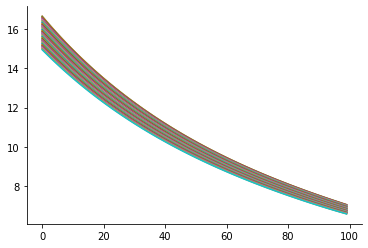

In [316]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [278]:
ξp = 5
ϵ = 0.1
max_iter = 5000
dmg_weight = np.array([1,1,1])/3
ϕ_weight = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
ϕ_equiv = - ξp*np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing = 'ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πa_o = np.ones((len(θ_list), num_y1, num_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2*y1_mat_cap

# initiate v and control
ems = η
ems_old = ems
lhs_error = 1
episode = 0
# v0 =  np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
v0 = ϕ_equiv[:num_y1]
while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0,0,1,hy1)
#     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
    v0_dy2 = derivatives_2d(v0,1,1,hy2)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
#     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
    # updating controls
    weight = np.array([-1/ξa*v0_dy2*λ*ems_old*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    print(np.min(ems))
    # HJB coefficient
    A =  -δ*np.ones(y1_mat_cap.shape)
    B_y1 =  y2_mat_cap
    B_y2 = λ*( - y2_mat_cap + ems*np.sum(θ_mat*πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat_cap + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    phi_mat = false_transient_one_iteration_python(A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, 
                                                   hy1, hy2, 
                                                   bc=(np.zeros(num_y2), ϕ_equiv[num_y1-1], np.zeros(num_y1), np.zeros(num_y1)), 
                                                   impose_bc=(False, True, False, False))
    rhs = A*phi_mat + B_y1*v0_dy1 + B_y2*v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat-v0_old)/ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

0.29318852032113685
Episode: 1	 lhs error: 0.059668660905	 rhs error: 0.086101918744
0.40458452254543037
Episode: 2	 lhs error: 0.057765288491	 rhs error: 0.095867496807
0.4530635181453566
Episode: 3	 lhs error: 0.054716722577	 rhs error: 0.101856120110
0.474353402439952
Episode: 4	 lhs error: 0.052454058032	 rhs error: 0.106865297300
0.48374000493478597
Episode: 5	 lhs error: 0.052423948330	 rhs error: 0.111401858589
0.48788567731832055
Episode: 6	 lhs error: 0.048422310206	 rhs error: 0.115405481735
0.4897180435026076
Episode: 7	 lhs error: 0.049134704438	 rhs error: 0.118951476599
0.49052821228887405
Episode: 8	 lhs error: 0.048103274455	 rhs error: 0.122138986982
0.4908864763360443
Episode: 9	 lhs error: 0.046191882170	 rhs error: 0.125041465373
0.49104491437355047
Episode: 10	 lhs error: 0.045974535570	 rhs error: 0.127437491905
0.49111498375526913
Episode: 11	 lhs error: 0.045638823953	 rhs error: 0.129712750328
0.49114597240748303
Episode: 12	 lhs error: 0.043120937635	 rhs erro

Episode: 97	 lhs error: 0.014689517864	 rhs error: 0.149337964024
0.4911705448439012
Episode: 98	 lhs error: 0.014600368707	 rhs error: 0.149404159713
0.4911705448437842
Episode: 99	 lhs error: 0.014513545268	 rhs error: 0.149572109422
0.49117054484388056
Episode: 100	 lhs error: 0.014426830354	 rhs error: 0.149513482766
0.4911705448439554
Episode: 101	 lhs error: 0.014340287825	 rhs error: 0.149430856603
0.4911705448437368
Episode: 102	 lhs error: 0.014253573030	 rhs error: 0.149454274590
0.49117054484380895
Episode: 103	 lhs error: 0.014166711128	 rhs error: 0.149538664029
0.4911705448439292
Episode: 104	 lhs error: 0.014080283392	 rhs error: 0.149423686866
0.49117054484386663
Episode: 105	 lhs error: 0.013993538135	 rhs error: 0.149526793074
0.4911705448439676
Episode: 106	 lhs error: 0.013907377572	 rhs error: 0.149422007851
0.4911705448438146
Episode: 107	 lhs error: 0.013820843349	 rhs error: 0.149603231481
0.49117054484390155
Episode: 108	 lhs error: 0.013734659244	 rhs error: 0

Episode: 192	 lhs error: 0.010877920975	 rhs error: 0.149279628782
0.4911705448437679
Episode: 193	 lhs error: 0.010859065795	 rhs error: 0.149331724604
0.49117054484383743
Episode: 194	 lhs error: 0.010839599713	 rhs error: 0.149452395124
0.4911705448439123
Episode: 195	 lhs error: 0.010820237875	 rhs error: 0.149422944831
0.49117054484396105
Episode: 196	 lhs error: 0.010800527408	 rhs error: 0.149381731957
0.4911705448440176
Episode: 197	 lhs error: 0.010781532905	 rhs error: 0.149289679367
0.4911705448439032
Episode: 198	 lhs error: 0.010761017703	 rhs error: 0.149458752896
0.49117054484394884
Episode: 199	 lhs error: 0.010740792699	 rhs error: 0.149431563116
0.4911705448439745
Episode: 200	 lhs error: 0.010720325138	 rhs error: 0.149401619955
0.4911705448439949
Episode: 201	 lhs error: 0.010699554552	 rhs error: 0.149362559000
0.4911705448440316
Episode: 202	 lhs error: 0.010679251154	 rhs error: 0.149290355283
0.49117054484376776
Episode: 203	 lhs error: 0.010658183202	 rhs error

Episode: 288	 lhs error: 0.009453958984	 rhs error: 0.149373123427
0.4911705448439539
Episode: 289	 lhs error: 0.009439839513	 rhs error: 0.149351135568
0.4911705448439666
Episode: 290	 lhs error: 0.009425511005	 rhs error: 0.149318332990
0.49117054484399425
Episode: 291	 lhs error: 0.009411605639	 rhs error: 0.149248565782
0.49117054484374734
Episode: 292	 lhs error: 0.009397035254	 rhs error: 0.149306207491
0.4911705448438377
Episode: 293	 lhs error: 0.009382179666	 rhs error: 0.149405826766
0.49117054484389683
Episode: 294	 lhs error: 0.009367380142	 rhs error: 0.149388205012
0.4911705448439294
Episode: 295	 lhs error: 0.009352423884	 rhs error: 0.149364865219
0.49117054484395006
Episode: 296	 lhs error: 0.009337235064	 rhs error: 0.149329145303
0.4911705448439879
Episode: 297	 lhs error: 0.009322647501	 rhs error: 0.149244112211
0.4911705448438768
Episode: 298	 lhs error: 0.009306902719	 rhs error: 0.149421942661
0.49117054484391026
Episode: 299	 lhs error: 0.009291426674	 rhs erro

Episode: 383	 lhs error: 0.008294053772	 rhs error: 0.149246331698
0.49117054484403094
Episode: 384	 lhs error: 0.008282763873	 rhs error: 0.149146509615
0.4911705448439023
Episode: 385	 lhs error: 0.008270486233	 rhs error: 0.149303428765
0.49117054484394007
Episode: 386	 lhs error: 0.008258437000	 rhs error: 0.149287148396
0.49117054484396105
Episode: 387	 lhs error: 0.008246269514	 rhs error: 0.149265972391
0.49117054484398237
Episode: 388	 lhs error: 0.008233900662	 rhs error: 0.149231963603
0.49117054484403166
Episode: 389	 lhs error: 0.008222175479	 rhs error: 0.149142346586
0.491170544843878
Episode: 390	 lhs error: 0.008209357607	 rhs error: 0.149328102513
0.4911705448439183
Episode: 391	 lhs error: 0.008196826881	 rhs error: 0.149318770516
0.4911705448439418
Episode: 392	 lhs error: 0.008184194908	 rhs error: 0.149309161251
0.4911705448439522
Episode: 393	 lhs error: 0.008171459892	 rhs error: 0.149297944300
0.4911705448439594
Episode: 394	 lhs error: 0.008158617336	 rhs error

Episode: 479	 lhs error: 0.007306866371	 rhs error: 0.149306847029
0.4911705448439515
Episode: 480	 lhs error: 0.007296062152	 rhs error: 0.149289122831
0.4911705448439607
Episode: 481	 lhs error: 0.007285143789	 rhs error: 0.149262137058
0.4911705448439879
Episode: 482	 lhs error: 0.007274527445	 rhs error: 0.149207575506
0.4911705448437481
Episode: 483	 lhs error: 0.007263575019	 rhs error: 0.149271114171
0.4911705448438066
Episode: 484	 lhs error: 0.007252261258	 rhs error: 0.149440411804
0.49117054484386946
Episode: 485	 lhs error: 0.007244153704	 rhs error: 0.149434325094
0.4911705448438962
Episode: 486	 lhs error: 0.007236519187	 rhs error: 0.149428533791
0.4911705448439081
Episode: 487	 lhs error: 0.007228818364	 rhs error: 0.149422709989
0.49117054484391504
Episode: 488	 lhs error: 0.007221051004	 rhs error: 0.149416604282
0.4911705448439172
Episode: 489	 lhs error: 0.007213216905	 rhs error: 0.149410015339
0.49117054484392275
Episode: 490	 lhs error: 0.007205315859	 rhs error:

Episode: 575	 lhs error: 0.006482638802	 rhs error: 0.149257586102
0.49117054484380823
Episode: 576	 lhs error: 0.006475450222	 rhs error: 0.149091905785
0.4911705448438756
Episode: 577	 lhs error: 0.006468097545	 rhs error: 0.149174205983
0.49117054484383177
Episode: 578	 lhs error: 0.006460340551	 rhs error: 0.149319487851
0.49117054484390443
Episode: 579	 lhs error: 0.006452735666	 rhs error: 0.149302380816
0.4911705448439468
Episode: 580	 lhs error: 0.006445059599	 rhs error: 0.149278092935
0.4911705448439755
Episode: 581	 lhs error: 0.006437212529	 rhs error: 0.149238057003
0.4911705448440553
Episode: 582	 lhs error: 0.006429841993	 rhs error: 0.149114352891
0.49117054484392764
Episode: 583	 lhs error: 0.006421760203	 rhs error: 0.149241868093
0.4911705448439807
Episode: 584	 lhs error: 0.006413839563	 rhs error: 0.149192795108
0.4911705448438435
Episode: 585	 lhs error: 0.006406144665	 rhs error: 0.149058298041
0.49117054484389777
Episode: 586	 lhs error: 0.006398241579	 rhs erro

Episode: 671	 lhs error: 0.005765722680	 rhs error: 0.149387093684
0.49117054484390676
Episode: 672	 lhs error: 0.005758034223	 rhs error: 0.149376719583
0.49117054484391987
Episode: 673	 lhs error: 0.005750297798	 rhs error: 0.149366265525
0.4911705448439305
Episode: 674	 lhs error: 0.005742512999	 rhs error: 0.149355089155
0.49117054484393796
Episode: 675	 lhs error: 0.005734679195	 rhs error: 0.149342495826
0.49117054484394207
Episode: 676	 lhs error: 0.005727670452	 rhs error: 0.149327484511
0.4911705448439524
Episode: 677	 lhs error: 0.005721698051	 rhs error: 0.149308414086
0.49117054484396594
Episode: 678	 lhs error: 0.005715665575	 rhs error: 0.149281601323
0.49117054484398726
Episode: 679	 lhs error: 0.005709412343	 rhs error: 0.149234991895
0.49117054484410616
Episode: 680	 lhs error: 0.005703697205	 rhs error: 0.149036267392
0.49117054484396794
Episode: 681	 lhs error: 0.005697599662	 rhs error: 0.149147000364
0.49117054484373945
Episode: 682	 lhs error: 0.005691643684	 rhs 

Episode: 767	 lhs error: 0.005149291289	 rhs error: 0.149496219633
0.4911705448397894
Episode: 768	 lhs error: 0.005142668361	 rhs error: 0.149244684006
0.4911705448421818
Episode: 769	 lhs error: 0.005136330578	 rhs error: 0.149255947529
0.4911705448432124
Episode: 770	 lhs error: 0.005129952509	 rhs error: 0.149256713092
0.4911705448436554
Episode: 771	 lhs error: 0.005123533451	 rhs error: 0.149250554281
0.49117054484384765
Episode: 772	 lhs error: 0.005117071127	 rhs error: 0.149238261525
0.4911705448439362
Episode: 773	 lhs error: 0.005110557257	 rhs error: 0.149217776984
0.4911705448439845
Episode: 774	 lhs error: 0.005103922041	 rhs error: 0.149180182267
0.49117054484408024
Episode: 775	 lhs error: 0.005097675517	 rhs error: 0.149061475128
0.4911705448439168
Episode: 776	 lhs error: 0.005090870887	 rhs error: 0.149215869260
0.4911705448439715
Episode: 777	 lhs error: 0.005084194518	 rhs error: 0.149192965036
0.4911705448440194
Episode: 778	 lhs error: 0.005077767138	 rhs error: 

Episode: 863	 lhs error: 0.004606087641	 rhs error: 0.149108820073
0.4911705448438807
Episode: 864	 lhs error: 0.004600741338	 rhs error: 0.149194528304
0.49117054484361555
Episode: 865	 lhs error: 0.004594960546	 rhs error: 0.149444498627
0.4911705448437902
Episode: 866	 lhs error: 0.004589366096	 rhs error: 0.149437768315
0.4911705448438666
Episode: 867	 lhs error: 0.004583740103	 rhs error: 0.149430936164
0.4911705448438988
Episode: 868	 lhs error: 0.004578081854	 rhs error: 0.149423763193
0.49117054484391587
Episode: 869	 lhs error: 0.004572391581	 rhs error: 0.149416362342
0.49117054484391764
Episode: 870	 lhs error: 0.004566669266	 rhs error: 0.149408602802
0.49117054484392486
Episode: 871	 lhs error: 0.004560914854	 rhs error: 0.149400366474
0.4911705448439262
Episode: 872	 lhs error: 0.004555128295	 rhs error: 0.149391489577
0.49117054484392686
Episode: 873	 lhs error: 0.004550079143	 rhs error: 0.149381803592
0.4911705448439317
Episode: 874	 lhs error: 0.004545372748	 rhs erro

Episode: 959	 lhs error: 0.004126214500	 rhs error: 0.149256281054
0.49117054484398565
Episode: 960	 lhs error: 0.004121085304	 rhs error: 0.149229390621
0.4911705448440128
Episode: 961	 lhs error: 0.004116846831	 rhs error: 0.149177453778
0.49117054484375455
Episode: 962	 lhs error: 0.004112594352	 rhs error: 0.149245639662
0.49117054484363876
Episode: 963	 lhs error: 0.004108314319	 rhs error: 0.149303497329
0.4911705448437851
Episode: 964	 lhs error: 0.004103974320	 rhs error: 0.149403399892
0.4911705448438625
Episode: 965	 lhs error: 0.004099645628	 rhs error: 0.149394612214
0.4911705448438943
Episode: 966	 lhs error: 0.004095291274	 rhs error: 0.149382915952
0.4911705448439128
Episode: 967	 lhs error: 0.004090911048	 rhs error: 0.149368634752
0.49117054484392464
Episode: 968	 lhs error: 0.004086504566	 rhs error: 0.149351553208
0.4911705448439362
Episode: 969	 lhs error: 0.004082070945	 rhs error: 0.149330740184
0.4911705448439494
Episode: 970	 lhs error: 0.004077607365	 rhs error

Episode: 1055	 lhs error: 0.003706811894	 rhs error: 0.149231763129
0.4911705448436524
Episode: 1056	 lhs error: 0.003702682111	 rhs error: 0.149291764726
0.49117054484378553
Episode: 1057	 lhs error: 0.003698490948	 rhs error: 0.149403885501
0.4911705448438562
Episode: 1058	 lhs error: 0.003694306888	 rhs error: 0.149395117002
0.49117054484389683
Episode: 1059	 lhs error: 0.003690100255	 rhs error: 0.149384181408
0.49117054484391576
Episode: 1060	 lhs error: 0.003685870966	 rhs error: 0.149371352371
0.491170544843924
Episode: 1061	 lhs error: 0.003681618900	 rhs error: 0.149356578892
0.4911705448439352
Episode: 1062	 lhs error: 0.003677343837	 rhs error: 0.149339449302
0.4911705448439436
Episode: 1063	 lhs error: 0.003673045284	 rhs error: 0.149318964865
0.4911705448439556
Episode: 1064	 lhs error: 0.003668721705	 rhs error: 0.149292817608
0.49117054484397626
Episode: 1065	 lhs error: 0.003664363559	 rhs error: 0.149254470096
0.49117054484402867
Episode: 1066	 lhs error: 0.00470083662

Episode: 1151	 lhs error: 0.003332094925	 rhs error: 0.149363059346
0.4911705448439386
Episode: 1152	 lhs error: 0.003328514603	 rhs error: 0.149348237361
0.4911705448439441
Episode: 1153	 lhs error: 0.003324915129	 rhs error: 0.149331765622
0.4911705448439485
Episode: 1154	 lhs error: 0.003321296428	 rhs error: 0.149312757673
0.4911705448439622
Episode: 1155	 lhs error: 0.003317658314	 rhs error: 0.149289470495
0.4911705448439756
Episode: 1156	 lhs error: 0.003313999925	 rhs error: 0.149257712766
0.49117054484400574
Episode: 1157	 lhs error: 0.003310304597	 rhs error: 0.149202353582
0.49117054484386125
Episode: 1158	 lhs error: 0.003306644694	 rhs error: 0.149056178854
0.49117054484390166
Episode: 1159	 lhs error: 0.003302931449	 rhs error: 0.149138904057
0.4911705448438635
Episode: 1160	 lhs error: 0.003299181220	 rhs error: 0.149257040825
0.49117054484394984
Episode: 1161	 lhs error: 0.003295423898	 rhs error: 0.149222962504
0.49117054484403483
Episode: 1162	 lhs error: 0.0033384606

Episode: 1248	 lhs error: 0.002995905240	 rhs error: 0.149345961281
0.4911705448439401
Episode: 1249	 lhs error: 0.002992618589	 rhs error: 0.149339094132
0.49117054484394773
Episode: 1250	 lhs error: 0.002989315386	 rhs error: 0.149331999854
0.49117054484393924
Episode: 1251	 lhs error: 0.002985995415	 rhs error: 0.149324483464
0.4911705448439445
Episode: 1252	 lhs error: 0.002982658926	 rhs error: 0.149316108462
0.49117054484395234
Episode: 1253	 lhs error: 0.002979305868	 rhs error: 0.149306623346
0.491170544843954
Episode: 1254	 lhs error: 0.002975936294	 rhs error: 0.149295626770
0.4911705448439629
Episode: 1255	 lhs error: 0.002972550314	 rhs error: 0.149282483616
0.49117054484396694
Episode: 1256	 lhs error: 0.002969148185	 rhs error: 0.149266076258
0.49117054484397143
Episode: 1257	 lhs error: 0.002965730672	 rhs error: 0.149244127243
0.49117054484399003
Episode: 1258	 lhs error: 0.002962301803	 rhs error: 0.149210541692
0.4911705448440387
Episode: 1259	 lhs error: 0.0029590243

Episode: 1344	 lhs error: 0.003725450894	 rhs error: 0.149110037855
0.49117054484386113
Episode: 1345	 lhs error: 0.002695593205	 rhs error: 0.149299468577
0.49117054484391565
Episode: 1346	 lhs error: 0.002692815314	 rhs error: 0.149292071969
0.49117054484394057
Episode: 1347	 lhs error: 0.002690023309	 rhs error: 0.149284173296
0.4911705448439553
Episode: 1348	 lhs error: 0.002687217419	 rhs error: 0.149275248979
0.49117054484396816
Episode: 1349	 lhs error: 0.002684397914	 rhs error: 0.149264653536
0.49117054484397576
Episode: 1350	 lhs error: 0.002681565267	 rhs error: 0.149251430211
0.49117054484398265
Episode: 1351	 lhs error: 0.002678720639	 rhs error: 0.149233876182
0.4911705448439949
Episode: 1352	 lhs error: 0.002675868512	 rhs error: 0.149208175075
0.4911705448440198
Episode: 1353	 lhs error: 0.002672952501	 rhs error: 0.149161449728
0.49117054484383693
Episode: 1354	 lhs error: 0.002670058267	 rhs error: 0.149088530450
0.4911705448438846
Episode: 1355	 lhs error: 0.00405740

Episode: 1439	 lhs error: 0.002435928992	 rhs error: 0.149369193986
0.49117054484393463
Episode: 1440	 lhs error: 0.002433182412	 rhs error: 0.149355606868
0.49117054484393885
Episode: 1441	 lhs error: 0.002430656785	 rhs error: 0.149341252658
0.49117054484394795
Episode: 1442	 lhs error: 0.002428176599	 rhs error: 0.149325789209
0.49117054484395567
Episode: 1443	 lhs error: 0.002425685039	 rhs error: 0.149308617676
0.4911705448439656
Episode: 1444	 lhs error: 0.002423183022	 rhs error: 0.149288652686
0.4911705448439766
Episode: 1445	 lhs error: 0.002420673301	 rhs error: 0.149263679893
0.4911705448439916
Episode: 1446	 lhs error: 0.002418170317	 rhs error: 0.149227847106
0.4911705448440356
Episode: 1447	 lhs error: 0.002415473898	 rhs error: 0.149154673355
0.4911705448437677
Episode: 1448	 lhs error: 0.004577641621	 rhs error: 0.149226707256
0.4911705448437392
Episode: 1449	 lhs error: 0.002410414094	 rhs error: 0.149462241781
0.4911705448438377
Episode: 1450	 lhs error: 0.00240783304

Episode: 1534	 lhs error: 0.002199810457	 rhs error: 0.149210871864
0.49117054484398137
Episode: 1535	 lhs error: 0.002197316585	 rhs error: 0.149180660657
0.4911705448440541
Episode: 1536	 lhs error: 0.002194566232	 rhs error: 0.149107672591
0.4911705448437684
Episode: 1537	 lhs error: 0.004409656580	 rhs error: 0.149186553641
0.4911705448437402
Episode: 1538	 lhs error: 0.002189520122	 rhs error: 0.149413827355
0.4911705448438407
Episode: 1539	 lhs error: 0.002186938243	 rhs error: 0.149405256241
0.4911705448438909
Episode: 1540	 lhs error: 0.002184344301	 rhs error: 0.149397554945
0.4911705448439112
Episode: 1541	 lhs error: 0.002181738627	 rhs error: 0.149390382714
0.49117054484391914
Episode: 1542	 lhs error: 0.002179121397	 rhs error: 0.149383468548
0.4911705448439282
Episode: 1543	 lhs error: 0.002176492716	 rhs error: 0.149376614445
0.49117054484393224
Episode: 1544	 lhs error: 0.002173852658	 rhs error: 0.149369663221
0.4911705448439341
Episode: 1545	 lhs error: 0.002171201267

Episode: 1630	 lhs error: 0.001904693761	 rhs error: 0.149328207920
0.49117054484394407
Episode: 1631	 lhs error: 0.001901099363	 rhs error: 0.149320574451
0.49117054484394496
Episode: 1632	 lhs error: 0.001897495431	 rhs error: 0.149312086531
0.4911705448439507
Episode: 1633	 lhs error: 0.001893882118	 rhs error: 0.149302519509
0.49117054484395595
Episode: 1634	 lhs error: 0.001890259719	 rhs error: 0.149291528691
0.49117054484396194
Episode: 1635	 lhs error: 0.001886628750	 rhs error: 0.149278572139
0.4911705448439655
Episode: 1636	 lhs error: 0.001882990308	 rhs error: 0.149262677021
0.49117054484397543
Episode: 1637	 lhs error: 0.001879347372	 rhs error: 0.149241857498
0.4911705448439937
Episode: 1638	 lhs error: 0.001875713850	 rhs error: 0.149211132628
0.4911705448440311
Episode: 1639	 lhs error: 0.001871858905	 rhs error: 0.149150133542
0.4911705448437648
Episode: 1640	 lhs error: 0.001868171426	 rhs error: 0.149222709348
0.49117054484364775
Episode: 1641	 lhs error: 0.002953916

Episode: 1725	 lhs error: 0.001525673822	 rhs error: 0.149387168782
0.4911705448439281
Episode: 1726	 lhs error: 0.001521378558	 rhs error: 0.149377549140
0.4911705448439312
Episode: 1727	 lhs error: 0.001517079228	 rhs error: 0.149367612792
0.4911705448439335
Episode: 1728	 lhs error: 0.001512776333	 rhs error: 0.149357212900
0.49117054484393563
Episode: 1729	 lhs error: 0.001508469637	 rhs error: 0.149346313866
0.49117054484394296
Episode: 1730	 lhs error: 0.001504159482	 rhs error: 0.149334666811
0.49117054484394707
Episode: 1731	 lhs error: 0.001499846132	 rhs error: 0.149321993950
0.4911705448439506
Episode: 1732	 lhs error: 0.001495530010	 rhs error: 0.149307857736
0.4911705448439559
Episode: 1733	 lhs error: 0.001491211879	 rhs error: 0.149291531442
0.4911705448439691
Episode: 1734	 lhs error: 0.001486893523	 rhs error: 0.149271634506
0.4911705448439807
Episode: 1735	 lhs error: 0.001482580918	 rhs error: 0.149245091745
0.49117054484400535
Episode: 1736	 lhs error: 0.00232734839

Episode: 1822	 lhs error: 0.001102259268	 rhs error: 0.149408284208
0.49117054484391764
Episode: 1823	 lhs error: 0.001097965634	 rhs error: 0.149397783887
0.4911705448439212
Episode: 1824	 lhs error: 0.001093676378	 rhs error: 0.149386860710
0.49117054484393097
Episode: 1825	 lhs error: 0.001089391627	 rhs error: 0.149375481111
0.4911705448439272
Episode: 1826	 lhs error: 0.001085111518	 rhs error: 0.149363538850
0.49117054484393263
Episode: 1827	 lhs error: 0.001080836269	 rhs error: 0.149350867937
0.4911705448439405
Episode: 1828	 lhs error: 0.001076566152	 rhs error: 0.149337198597
0.49117054484394795
Episode: 1829	 lhs error: 0.001072301586	 rhs error: 0.149322088327
0.49117054484395567
Episode: 1830	 lhs error: 0.001068043356	 rhs error: 0.149304797727
0.4911705448439646
Episode: 1831	 lhs error: 0.001063793266	 rhs error: 0.149283906655
0.491170544843974
Episode: 1832	 lhs error: 0.001059557562	 rhs error: 0.149256226928
0.4911705448439967
Episode: 1833	 lhs error: 0.00256343323

Episode: 1918	 lhs error: 0.000719571983	 rhs error: 0.149293448016
0.49117054484397416
Episode: 1919	 lhs error: 0.000716013764	 rhs error: 0.149266551486
0.49117054484399547
Episode: 1920	 lhs error: 0.002072917424	 rhs error: 0.149224649647
0.49117054484406764
Episode: 1921	 lhs error: 0.002848797153	 rhs error: 0.149109527160
0.49117054484391043
Episode: 1922	 lhs error: 0.000705337824	 rhs error: 0.149251278783
0.49117054484396183
Episode: 1923	 lhs error: 0.000701821387	 rhs error: 0.149228591545
0.49117054484399786
Episode: 1924	 lhs error: 0.002008904632	 rhs error: 0.149190625745
0.4911705448440826
Episode: 1925	 lhs error: 0.003008911398	 rhs error: 0.149081291382
0.49117054484391415
Episode: 1926	 lhs error: 0.000691261116	 rhs error: 0.149232990312
0.4911705448439619
Episode: 1927	 lhs error: 0.000687782224	 rhs error: 0.149214054599
0.4911705448439979
Episode: 1928	 lhs error: 0.001350868976	 rhs error: 0.149183078340
0.4911705448440597
Episode: 1929	 lhs error: 0.00098707

Episode: 2013	 lhs error: 0.000427943262	 rhs error: 0.149399240204
0.49117054484391065
Episode: 2014	 lhs error: 0.000425408475	 rhs error: 0.149391973043
0.49117054484389777
Episode: 2015	 lhs error: 0.000422885445	 rhs error: 0.149384536984
0.49117054484391615
Episode: 2016	 lhs error: 0.000420373194	 rhs error: 0.149377062762
0.4911705448439241
Episode: 2017	 lhs error: 0.000417872118	 rhs error: 0.149369208249
0.49117054484392764
Episode: 2018	 lhs error: 0.000415382303	 rhs error: 0.149360805565
0.49117054484393563
Episode: 2019	 lhs error: 0.000412903814	 rhs error: 0.149351680683
0.4911705448439383
Episode: 2020	 lhs error: 0.000410436764	 rhs error: 0.149341624320
0.4911705448439395
Episode: 2021	 lhs error: 0.000407981314	 rhs error: 0.149330347013
0.4911705448439482
Episode: 2022	 lhs error: 0.000405537795	 rhs error: 0.149317395663
0.4911705448439503
Episode: 2023	 lhs error: 0.000403106865	 rhs error: 0.149302016626
0.4911705448439606
Episode: 2024	 lhs error: 0.0004424015

Episode: 2107	 lhs error: 0.002036475625	 rhs error: 0.149314653389
0.4911705448437852
Episode: 2108	 lhs error: 0.000233932736	 rhs error: 0.149419995880
0.4911705448438588
Episode: 2109	 lhs error: 0.000232361113	 rhs error: 0.149411278618
0.49117054484389144
Episode: 2110	 lhs error: 0.000230798750	 rhs error: 0.149400410208
0.49117054484390965
Episode: 2111	 lhs error: 0.000229245538	 rhs error: 0.149387860986
0.4911705448439184
Episode: 2112	 lhs error: 0.000234879310	 rhs error: 0.149373753161
0.4911705448439261
Episode: 2113	 lhs error: 0.000275499631	 rhs error: 0.149357910572
0.4911705448439371
Episode: 2114	 lhs error: 0.000337782034	 rhs error: 0.149339762897
0.4911705448439463
Episode: 2115	 lhs error: 0.000451570335	 rhs error: 0.149318098641
0.4911705448439578
Episode: 2116	 lhs error: 0.000725004208	 rhs error: 0.149290063308
0.4911705448439758
Episode: 2117	 lhs error: 0.002126332632	 rhs error: 0.149246932847
0.49117054484405165
Episode: 2118	 lhs error: 0.002679594517

Episode: 2203	 lhs error: 0.000195527183	 rhs error: 0.149347024904
0.49117054484394607
Episode: 2204	 lhs error: 0.000226021137	 rhs error: 0.149334804660
0.4911705448439492
Episode: 2205	 lhs error: 0.000274122064	 rhs error: 0.149320694211
0.49117054484395506
Episode: 2206	 lhs error: 0.000357138572	 rhs error: 0.149303715813
0.49117054484396544
Episode: 2207	 lhs error: 0.000528435995	 rhs error: 0.149281936832
0.49117054484397904
Episode: 2208	 lhs error: 0.001058393476	 rhs error: 0.149250493007
0.491170544844007
Episode: 2209	 lhs error: 0.000767663188	 rhs error: 0.149189878325
0.4911705448437569
Episode: 2210	 lhs error: 0.004338029524	 rhs error: 0.149256487416
0.49117054484356815
Episode: 2211	 lhs error: 0.000193215075	 rhs error: 0.149505974142
0.4911705448437677
Episode: 2212	 lhs error: 0.000183796981	 rhs error: 0.149497757569
0.49117054484385003
Episode: 2213	 lhs error: 0.000172263364	 rhs error: 0.149488969731
0.4911705448438839
Episode: 2214	 lhs error: 0.0001628641

Episode: 2297	 lhs error: 0.000196355498	 rhs error: 0.149367233636
0.4911705448439345
Episode: 2298	 lhs error: 0.000215290116	 rhs error: 0.149354906976
0.49117054484393763
Episode: 2299	 lhs error: 0.000246713843	 rhs error: 0.149341281808
0.4911705448439465
Episode: 2300	 lhs error: 0.000298977950	 rhs error: 0.149325692148
0.49117054484395223
Episode: 2301	 lhs error: 0.000394187330	 rhs error: 0.149306995789
0.49117054484395944
Episode: 2302	 lhs error: 0.000606548487	 rhs error: 0.149282822109
0.4911705448439767
Episode: 2303	 lhs error: 0.001408134983	 rhs error: 0.149246735467
0.4911705448440263
Episode: 2304	 lhs error: 0.003907744046	 rhs error: 0.149166793690
0.4911705448436883
Episode: 2305	 lhs error: 0.000175317088	 rhs error: 0.149384212084
0.49117054484382616
Episode: 2306	 lhs error: 0.000166622079	 rhs error: 0.149376522000
0.49117054484388634
Episode: 2307	 lhs error: 0.000163454298	 rhs error: 0.149368423884
0.49117054484391187
Episode: 2308	 lhs error: 0.000166311

Episode: 2394	 lhs error: 0.000332541024	 rhs error: 0.149439498037
0.4911705448438562
Episode: 2395	 lhs error: 0.000244982570	 rhs error: 0.149428721599
0.4911705448438894
Episode: 2396	 lhs error: 0.000199425645	 rhs error: 0.149419579821
0.4911705448439143
Episode: 2397	 lhs error: 0.000172155249	 rhs error: 0.149411487583
0.4911705448439244
Episode: 2398	 lhs error: 0.000154274894	 rhs error: 0.149404017266
0.4911705448439277
Episode: 2399	 lhs error: 0.000143662345	 rhs error: 0.149396835844
0.49117054484393097
Episode: 2400	 lhs error: 0.000138650899	 rhs error: 0.149389679069
0.4911705448439336
Episode: 2401	 lhs error: 0.000138638982	 rhs error: 0.149382344347
0.49117054484393186
Episode: 2402	 lhs error: 0.000142718320	 rhs error: 0.149374627728
0.4911705448439312
Episode: 2403	 lhs error: 0.000150967458	 rhs error: 0.149366361320
0.49117054484393274
Episode: 2404	 lhs error: 0.000164091999	 rhs error: 0.149357357666
0.4911705448439371
Episode: 2405	 lhs error: 0.000183236753

Episode: 2491	 lhs error: 0.000220154260	 rhs error: 0.149469247827
0.4911705448438969
Episode: 2492	 lhs error: 0.000191560415	 rhs error: 0.149458996386
0.4911705448439063
Episode: 2493	 lhs error: 0.000172097319	 rhs error: 0.149449534957
0.4911705448439142
Episode: 2494	 lhs error: 0.000159381236	 rhs error: 0.149440525341
0.4911705448439168
Episode: 2495	 lhs error: 0.000151728697	 rhs error: 0.149431724200
0.49117054484391715
Episode: 2496	 lhs error: 0.000148169973	 rhs error: 0.149422948646
0.4911705448439227
Episode: 2497	 lhs error: 0.000148085681	 rhs error: 0.149414045533
0.4911705448439261
Episode: 2498	 lhs error: 0.000150964997	 rhs error: 0.149404875779
0.4911705448439284
Episode: 2499	 lhs error: 0.000156720598	 rhs error: 0.149395316571
0.49117054484392875
Episode: 2500	 lhs error: 0.000165994784	 rhs error: 0.149385241785
0.4911705448439315
Episode: 2501	 lhs error: 0.000179273716	 rhs error: 0.149374475600
0.4911705448439328
Episode: 2502	 lhs error: 0.000198300462	

Episode: 2588	 lhs error: 0.000350484279	 rhs error: 0.149382418880
0.4911705448438791
Episode: 2589	 lhs error: 0.000261639489	 rhs error: 0.149374748307
0.49117054484391326
Episode: 2590	 lhs error: 0.000196973157	 rhs error: 0.149368459310
0.4911705448439265
Episode: 2591	 lhs error: 0.000149570791	 rhs error: 0.149362926191
0.49117054484393324
Episode: 2592	 lhs error: 0.000132386962	 rhs error: 0.149357696998
0.4911705448439363
Episode: 2593	 lhs error: 0.000127429693	 rhs error: 0.149352409798
0.49117054484393874
Episode: 2594	 lhs error: 0.000128611518	 rhs error: 0.149346790476
0.49117054484393974
Episode: 2595	 lhs error: 0.000135813748	 rhs error: 0.149340601831
0.4911705448439402
Episode: 2596	 lhs error: 0.000148943580	 rhs error: 0.149333582915
0.4911705448439413
Episode: 2597	 lhs error: 0.000169614819	 rhs error: 0.149325460135
0.4911705448439436
Episode: 2598	 lhs error: 0.000200726234	 rhs error: 0.149315850036
0.49117054484395195
Episode: 2599	 lhs error: 0.0002489594

Episode: 2684	 lhs error: 0.000748262872	 rhs error: 0.149194988777
0.4911705448437537
Episode: 2685	 lhs error: 0.000590599323	 rhs error: 0.149260829091
0.4911705448436413
Episode: 2686	 lhs error: 0.001724978506	 rhs error: 0.149316651718
0.49117054484378614
Episode: 2687	 lhs error: 0.000152911622	 rhs error: 0.149404480616
0.4911705448438573
Episode: 2688	 lhs error: 0.000212448089	 rhs error: 0.149392333764
0.4911705448438962
Episode: 2689	 lhs error: 0.000271348406	 rhs error: 0.149376930899
0.49117054484391687
Episode: 2690	 lhs error: 0.000348409095	 rhs error: 0.149358270252
0.491170544843934
Episode: 2691	 lhs error: 0.000481746000	 rhs error: 0.149335326105
0.49117054484394596
Episode: 2692	 lhs error: 0.000815455253	 rhs error: 0.149304977288
0.4911705448439686
Episode: 2693	 lhs error: 0.003259360093	 rhs error: 0.149256269310
0.49117054484408074
Episode: 2694	 lhs error: 0.002200024880	 rhs error: 0.149075776881
0.4911705448439546
Episode: 2695	 lhs error: 0.002305388147

Episode: 2779	 lhs error: 0.000205282278	 rhs error: 0.149466077772
0.4911705448438456
Episode: 2780	 lhs error: 0.000178694351	 rhs error: 0.149457201012
0.4911705448438875
Episode: 2781	 lhs error: 0.000160995209	 rhs error: 0.149448832840
0.49117054484390443
Episode: 2782	 lhs error: 0.000150007541	 rhs error: 0.149440711695
0.4911705448439089
Episode: 2783	 lhs error: 0.000144187368	 rhs error: 0.149432638054
0.4911705448439127
Episode: 2784	 lhs error: 0.000142181236	 rhs error: 0.149424446402
0.49117054484391875
Episode: 2785	 lhs error: 0.000143054815	 rhs error: 0.149416015495
0.49117054484392175
Episode: 2786	 lhs error: 0.000146717476	 rhs error: 0.149407250955
0.491170544843923
Episode: 2787	 lhs error: 0.000152814168	 rhs error: 0.149398043142
0.49117054484393163
Episode: 2788	 lhs error: 0.000161676533	 rhs error: 0.149388293213
0.4911705448439329
Episode: 2789	 lhs error: 0.000174195601	 rhs error: 0.149377871182
0.49117054484393274
Episode: 2790	 lhs error: 0.00019186983

Episode: 2875	 lhs error: 0.000336275844	 rhs error: 0.149328407036
0.4911705448439442
Episode: 2876	 lhs error: 0.000466822099	 rhs error: 0.149307464519
0.49117054484395756
Episode: 2877	 lhs error: 0.000801802616	 rhs error: 0.149279127666
0.49117054484398226
Episode: 2878	 lhs error: 0.003221178925	 rhs error: 0.149232215278
0.49117054484409683
Episode: 2879	 lhs error: 0.002274969802	 rhs error: 0.149054540909
0.49117054484395833
Episode: 2880	 lhs error: 0.002016432860	 rhs error: 0.149163138031
0.49117054484380773
Episode: 2881	 lhs error: 0.001682736903	 rhs error: 0.149091377349
0.4911705448438773
Episode: 2882	 lhs error: 0.002290866855	 rhs error: 0.149171061268
0.491170544843863
Episode: 2883	 lhs error: 0.000475658611	 rhs error: 0.149289097133
0.49117054484392086
Episode: 2884	 lhs error: 0.000828679079	 rhs error: 0.149261014509
0.49117054484396955
Episode: 2885	 lhs error: 0.002224733775	 rhs error: 0.149213094939
0.4911705448438174
Episode: 2886	 lhs error: 0.001711986

Episode: 2969	 lhs error: 0.001418071906	 rhs error: 0.149247796137
0.49117054484402356
Episode: 2970	 lhs error: 0.003813164707	 rhs error: 0.149167181719
0.49117054484369593
Episode: 2971	 lhs error: 0.000172737226	 rhs error: 0.149379874733
0.4911705448438332
Episode: 2972	 lhs error: 0.000167233080	 rhs error: 0.149372062593
0.49117054484389133
Episode: 2973	 lhs error: 0.000167752727	 rhs error: 0.149363702842
0.49117054484391864
Episode: 2974	 lhs error: 0.000174303125	 rhs error: 0.149354653732
0.49117054484393075
Episode: 2975	 lhs error: 0.000188601242	 rhs error: 0.149344725642
0.49117054484393524
Episode: 2976	 lhs error: 0.000213206472	 rhs error: 0.149333589538
0.4911705448439392
Episode: 2977	 lhs error: 0.000253982078	 rhs error: 0.149320742480
0.4911705448439463
Episode: 2978	 lhs error: 0.000323852778	 rhs error: 0.149305326120
0.4911705448439578
Episode: 2979	 lhs error: 0.000461329769	 rhs error: 0.149285751174
0.49117054484396844
Episode: 2980	 lhs error: 0.00082856

KeyboardInterrupt: 

In [279]:
y1_grid_cap.shape

(51,)

In [280]:
ϕ_equiv.shape, n_y1, ϕ_equiv[:n_y1].shape

((100, 50), 100, (100, 50))

In [281]:
phi_mat[-1] - ϕ_equiv[numy_bar]

array([-4.76618744e-13, -4.12558876e-13, -3.46112028e-13, -2.76889622e-13,
       -2.04891659e-13, -1.30645494e-13, -5.38458167e-14,  2.53443100e-14,
        1.07039377e-13,  1.91291427e-13,  2.78221890e-13,  3.67705866e-13,
        4.59854377e-13,  5.55111512e-13,  6.53033183e-13,  7.54063478e-13,
        8.57536264e-13,  9.64339719e-13,  1.07469589e-12,  1.18771659e-12,
        1.30473410e-12,  1.42419410e-12,  1.54742885e-12,  1.67399428e-12,
        1.80389037e-12,  1.93800531e-12,  2.07656115e-12,  2.21689334e-12,
        2.36166642e-12,  2.51088039e-12,  2.66409117e-12,  2.82174284e-12,
        2.98205904e-12,  3.14770432e-12,  3.31690231e-12,  3.48965301e-12,
        3.66817687e-12,  3.85114163e-12,  4.03765910e-12,  4.22772928e-12,
        4.42401671e-12,  4.62474503e-12,  4.82902607e-12,  5.03863617e-12,
        5.25179900e-12,  5.47295542e-12,  5.69500003e-12,  5.92326188e-12,
        6.15241191e-12,  6.38955555e-12])

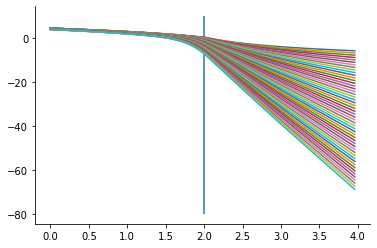

In [282]:
plt.plot(y1_grid[:numy_bar+1],phi_mat)
plt.plot(y1_grid[numy_bar:], ϕ_equiv[numy_bar:])
plt.vlines(2, ymax=10, ymin=-80)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (51,)

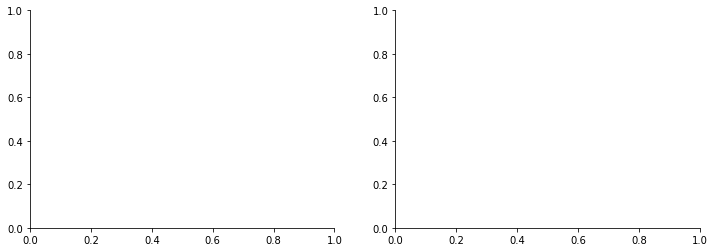

In [242]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], ems[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [156]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [186]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = y2_0 - λ*y2_0 + λ*θ*Et[i] 
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [249]:
et_list = list()
for γ3 in γ3_list:
    Y1t,Y2t, Et = simualte_ems(y1_grid, y2_grid, solu[γ3]["ems"],  dt=1/4)
    et_list.append(Et)

In [294]:
et_list_compare = list()
for γ3 in γ3_list:
    Et, Y1t,Y2t,  = simulation(y1_grid, y2_grid, solu[γ3]["ems"], λ, θ=np.mean(θ_list), y2_0=np.mean(θ_list))
    et_list_compare.append(Et)

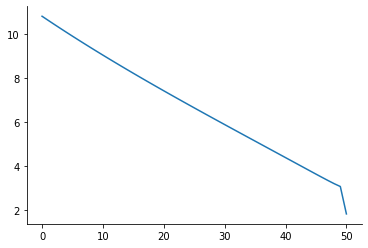

In [284]:
plt.plot(ems[:,0])

In [291]:
Y1t_jump,Y2t_jump, Et_jump = simualte_ems(y1_grid[:numy_bar+1], y2_grid, ems,  dt=1/4)

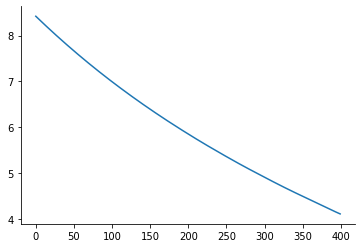

In [292]:
plt.plot(Et_jump)

(0.0, 14.938519166361448)

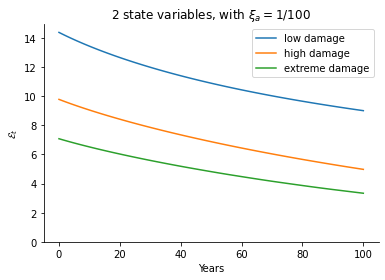

In [295]:
# years = np.arange(0, 100)
for et, dmg in zip(et_list_compare, ["low", "high", "extreme"]):
    plt.plot(et, label=dmg+" damage")
plt.legend()
plt.title("2 state variables, with $\\xi_a = 1/100$")
plt.xlabel("Years")
plt.ylabel("$\mathcal{E}_t$")
plt.ylim(0)
# plt.savefig("2state_ems.png", dpi=128, facecolor="w", edgecolor="w", bbox_inches="tight")

In [296]:
et_list_compare[0]

array([14.38605019, 14.28160053, 14.17961706, 14.07993943, 13.98289768,
       13.88777467, 13.79439829, 13.70343825, 13.61393076, 13.52632166,
       13.44030241, 13.35586415, 13.27297318, 13.19152716, 13.1114758 ,
       13.03284699, 12.95539264, 12.87942728, 12.80434952, 12.73089279,
       12.65823922, 12.5869707 , 12.51664534, 12.44738408, 12.37926055,
       12.31188758, 12.24584628, 12.18043933, 12.11618528, 12.05270444,
       11.99009413, 11.92845307, 11.86742093, 11.80753619, 11.74815163,
       11.68979607, 11.63203571, 11.57508076, 11.51887652, 11.46329013,
       11.40860051, 11.35430822, 11.30098568, 11.2480216 , 11.19595664,
       11.14430906, 11.09341569, 11.04303044, 10.99329117, 10.9441425 ,
       10.89554777, 10.84760378, 10.80004016, 10.75314191, 10.70661577,
       10.66076997, 10.6152378 , 10.57040741, 10.52585265, 10.4820228 ,
       10.43844268, 10.39559536, 10.35297758, 10.31100387, 10.26922582,
       10.22809701, 10.18717361, 10.14685845, 10.10676103, 10.06

ValueError: x and y must have same first dimension, but have shapes (400,) and (101,)

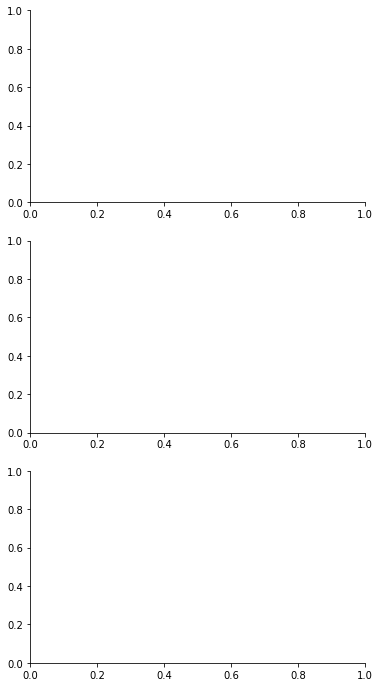

In [255]:
years = np.arange(0,100, 1/4)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,12))
ax1.plot(years, Et)
# ax1.plot(y1_mat[:,0], ems[:,49], label="$y_2$ = {:.2f}".format(y2_mat[0,49]))
# ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}_t$', size=20)
ax1.set_xlabel("Years", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
# ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(years, Y1t, label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.set_title('$Y^1_t$', size=20)
ax2.set_xlabel('Years', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
# ax2.legend()
# ax2.set_ylim(0,12)

ax3.plot(years, Y2t)
ax3.set_title('$Y_t^2$', size=20)
ax3.set_xlabel('Years', size=20)
ax3.set_ylim(0)
ax3.set_xlim(0)
fig.tight_layout()
# plt.savefig("simulation.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [ ]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [ ]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [ ]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, dt=1/4)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/Et*1000

In [ ]:
plt.plot(years, scc)

In [168]:
# ξₘ is 1000, no ambiguity over damage
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)
ς = 0.1
ξa = 1/100
ξw = 1000
ξp = 5
σy = 1e-5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_1, et_1 = simulate_ems_1d(y_grid[:numy_bar+1], solu["ems"], dt=1/4)

episode: 5000,	 ode error: 9.905671455526233e-05,	 ft error: 3.316203585068678e-05
episode: 5000,	 ode error: 0.0004189112227439215,	 ft error: 2.3994517419301253e-05
episode: 812,	 ode error: 0.0020503496427756313,	 ft error: 9.875385842406104e-09
episode: 5000,	 ode error: 0.0015449065580850421,	 ft error: 1.7729717254388877e-05


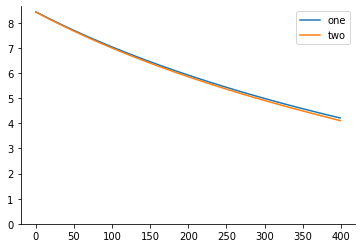

In [288]:
plt.plot(et_1, label="one")
plt.plot(Et_jump, label="two")
plt.ylim(0)
plt.legend()

In [167]:
def simulate_ems_1d(y1_grid, ems_1d, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
#     Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp1d(y1_grid, ems_1d,)
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y1)
        ems_t[t] = ems_point
        Y1t[t] = y1
#         Y2t[t] = y2
        y1 += ems_point*θ*dt
#         y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, ems_t

In [ ]:
y1_1d, et_1d = simualte_ems_1d(y1_grid, ems_1d, dt=1/4)

In [ ]:
plt.plot(years, et_1d)
plt.plot(years, Et)
plt.xlim(0)
plt.ylim(0, 20)

In [ ]:
scc_1d =  η*(α - invkap)*np.exp(Kt)/(1-η)/et_1d*1000
plt.plot(years, scc_1d, label="pde")
plt.plot(years, scc, label="ode")
plt.legend()